# CAPSTONE PROJECT

## Context about capstone project
You and your friend came up with a brilliant startup idea - provide risk evaluation as a service for retail banks. As with most successful startup teams, both of you have your specialty. Your friend is responsible for sales and operations, while you are responsible for everything product-related, from planning to data analysis to building the solution. You have quickly identified that machine learning will be an essential part of your offering because you believe that the models can capture statistical patterns in the defaults on bank loans. You decide to start your investigation by downloading this dataset from Home Credit Group. You are not yet sure, what is the most crucial problem for your potential clients, so you had a meeting with your friend to discuss how your proof-of-concept (POC) product should look like. After a lot of arguing, you both agreed to create a number of different models so that you have a robust and diversified offering when you get your first meeting with the potential clients. You are eager to investigate the dataset and see what you can predict, so you propose that you come up with interesting features to analyze and predict - this way, you'll focus on building a solid offering, and she can work on getting meetings with the banks.

### Approach
- load the data
- see relatioships between target and other features
- plot the most import features and explain details, use statistics inference
- combine extra data, make new features
- apply feature selction method
- trained baseline models
- improve selected model

### About Dataset
Generally, the data in the field of Finances tend to be very much variant and collecting such data can be very tedious task, but in this case, Home Credit has done most of the heavy lifting to provide us as clean of a data as possible. The dataset provided contains a vast number of details about the borrower. It is separated into several relational tables, which contain applicants’ static data such as their gender, age, number of family members, occupation, and other necessary fields, applicant’s previous credit history obtained from the credit bureau department, and the applicant’s past credit history within the Home Credit Group itself.

The Dataset can be downloaded from [this](https://storage.googleapis.com/341-home-credit-default/home-credit-default-risk.zip).

# 1. Setup

In [141]:
# Code formatter
%load_ext nb_black

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [142]:
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

# for statistic
from numpy import random
from scipy.stats import t
import scipy.stats as stats
import statsmodels.api as sm

# for model
from sklearn import metrics
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    cross_val_predict,
    cross_val_score,
    GridSearchCV,
)
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    classification_report,
)
from numpy import sqrt, argmax
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV
from imblearn.over_sampling import SMOTE, RandomOverSampler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import optuna
from sklearn.utils import class_weight
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline as ImPipeline
import csv
import sqlite3

from sklearn.preprocessing import (
    StandardScaler,
    LabelEncoder,
    OneHotEncoder,
)
import phik
from phik.report import plot_correlation_matrix
from phik import report

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import re

import warnings

warnings.filterwarnings("ignore")

# for 100% jupyter notebook cell width
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:70% !important; }</style>"))

# pandas DataFrame column and row display limits
pd.set_option("max_columns", None)
pd.set_option("max_rows", None)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

<IPython.core.display.Javascript object>

# 2. Upload the Dataset

In [143]:
# Load data into dataframes
application_train = pd.read_csv("./home-credit-default-risk/application_train.csv")
application_test = pd.read_csv("./home-credit-default-risk/application_test.csv")
bureau = pd.read_csv("./home-credit-default-risk/bureau.csv")
bureau_balance = pd.read_csv("./home-credit-default-risk/bureau_balance.csv")
credit_card_balance = pd.read_csv("./home-credit-default-risk/credit_card_balance.csv")
installments_payments = pd.read_csv(
    "./home-credit-default-risk/installments_payments.csv"
)
pos_cash_balance = pd.read_csv("./home-credit-default-risk/POS_CASH_balance.csv")
previous_application = pd.read_csv(
    "./home-credit-default-risk/previous_application.csv"
)
columns_description = pd.read_csv("./home-credit-default-risk/sample_submission.csv")

<IPython.core.display.Javascript object>

**application{train|test}.csv**

This is the main table, broken into two files for Train (with TARGET) and Test (without TARGET).
Static data for all applications. One row represents one loan in our data sample.

**bureau.csv**

All client's previous credits provided by other financial institutions that were reported to Credit Bureau (for clients who have a loan in our sample).
For every loan in our sample, there are as many rows as number of credits the client had in Credit Bureau before the application date.

**bureau_balance.csv**

Monthly balances of previous credits in Credit Bureau.
This table has one row for each month of history of every previous credit reported to Credit Bureau – i.e the table has (#loans in sample * # of relative previous credits * # of months where we have some history observable for the previous credits) rows.

**POS_CASH_balance.csv**

Monthly balance snapshots of previous POS (point of sales) and cash loans that the applicant had with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credits * # of months in which we have some history observable for the previous credits) rows.

**credit_card_balance.csv**

Monthly balance snapshots of previous credit cards that the applicant has with Home Credit.
This table has one row for each month of history of every previous credit in Home Credit (consumer credit and cash loans) related to loans in our sample – i.e. the table has (#loans in sample * # of relative previous credit cards * # of months where we have some history observable for the previous credit card) rows.

**previous_application.csv**

All previous applications for Home Credit loans of clients who have loans in our sample.
There is one row for each previous application related to loans in our data sample.

**installments_payments.csv**

Repayment history for the previously disbursed credits in Home Credit related to the loans in our sample.
There is a) one row for every payment that was made plus b) one row each for missed payment.
One row is equivalent to one payment of one installment OR one installment corresponding to one payment of one previous Home Credit credit related to loans in our sample.

In [144]:
print("application_train     :", application_train.shape)
print("application_test      :", application_test.shape)
print("bureau                :", bureau.shape)
print("bureau_balance        :", bureau_balance.shape)
print("credit_card_balance   :", credit_card_balance.shape)
print("installments_payments :", installments_payments.shape)
print("pos_cash_balance      :", pos_cash_balance.shape)
print("previous_application  :", previous_application.shape)

application_train     : (307511, 122)
application_test      : (48744, 121)
bureau                : (1716428, 17)
bureau_balance        : (27299925, 3)
credit_card_balance   : (3840312, 23)
installments_payments : (13605401, 8)
pos_cash_balance      : (10001358, 8)
previous_application  : (1670214, 37)


<IPython.core.display.Javascript object>

### First few rows

In [145]:
display("application_train")
display(application_train.head(3))
display("application_test")
display(application_test.head(3))
display("bureau")
display(bureau.head(3))
display("bureau_balance")
display(bureau_balance.head(3))
display("credit_card_balance")
display(credit_card_balance.head(3))
display("installments_payments")
display(installments_payments.head(3))
display("pos_cash_balance")
display(pos_cash_balance.head(3))
display("previous_application")
display(previous_application.head(3))

'application_train'

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100002,1,Cash loans,M,N,Y,0,202500.0000,406597.5000,24700.5000,351000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0188,-9461,-637,-3648.0000,-2120,nan,1,1,0,1,1,0,Laborers,1.0000,2,2,WEDNESDAY,10,0,0,0,0,0,0,Business Entity Type 3,0.0830,0.2629,0.1394,0.0247,0.0369,0.9722,0.6192,0.0143,0.0000,0.0690,0.0833,0.1250,0.0369,0.0202,0.0190,0.0000,0.0000,0.0252,0.0383,0.9722,0.6341,0.0144,0.0000,0.0690,0.0833,0.1250,0.0377,0.0220,0.0198,0.0000,0.0000,0.0250,0.0369,0.9722,0.6243,0.0144,0.0000,0.0690,0.0833,0.1250,0.0375,0.0205,0.0193,0.0000,0.0000,reg oper account,block of flats,0.0149,"Stone, brick",No,2.0000,2.0000,2.0000,2.0000,-1134.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
1,100003,0,Cash loans,F,N,N,0,270000.0000,1293502.5000,35698.5000,1129500.0000,Family,State servant,Higher education,Married,House / apartment,0.0035,-16765,-1188,-1186.0000,-291,nan,1,1,0,1,1,0,Core staff,2.0000,1,1,MONDAY,11,0,0,0,0,0,0,School,0.3113,0.6222,nan,0.0959,0.0529,0.9851,0.7960,0.0605,0.0800,0.0345,0.2917,0.3333,0.0130,0.0773,0.0549,0.0039,0.0098,0.0924,0.0538,0.9851,0.8040,0.0497,0.0806,0.0345,0.2917,0.3333,0.0128,0.0790,0.0554,0.0000,0.0000,0.0968,0.0529,0.9851,0.7987,0.0608,0.0800,0.0345,0.2917,0.3333,0.0132,0.0787,0.0558,0.0039,0.0100,reg oper account,block of flats,0.0714,Block,No,1.0000,0.0000,1.0000,0.0000,-828.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,100004,0,Revolving loans,M,Y,Y,0,67500.0000,135000.0000,6750.0000,135000.0000,Unaccompanied,Working,Secondary / secondary special,Single / not married,House / apartment,0.0100,-19046,-225,-4260.0000,-2531,26.0000,1,1,1,1,1,0,Laborers,1.0000,2,2,MONDAY,9,0,0,0,0,0,0,Government,nan,0.5559,0.

'application_test'

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,ORGANIZATION_TYPE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,FONDKAPREMONT_MODE,HOUSETYPE_MODE,TOTALAREA_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,100001,Cash loans,F,N,Y,0,135000.0000,568800.0000,20560.5000,450000.0000,Unaccompanied,Working,Higher education,Married,House / apartment,0.0188,-19241,-2329,-5170.0000,-812,nan,1,1,0,1,0,1,NaN,2.0000,2,2,TUESDAY,18,0,0,0,0,0,0,Kindergarten,0.7526,0.7897,0.1595,0.0660,0.0590,0.9732,nan,nan,nan,0.1379,0.1250,nan,nan,nan,0.0505,nan,nan,0.0672,0.0612,0.9732,nan,nan,nan,0.1379,0.1250,nan,nan,nan,0.0526,nan,nan,0.0666,0.0590,0.9732,nan,nan,nan,0.1379,0.1250,nan,nan,nan,0.0514,nan,nan,NaN,block of flats,0.0392,"Stone, brick",No,0.0000,0.0000,0.0000,0.0000,-1740.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,100005,Cash loans,M,N,Y,0,99000.0000,222768.0000,17370.0000,180000.0000,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,0.0358,-18064,-4469,-9118.0000,-1623,nan,1,1,0,1,0,0,Low-skill Laborers,2.0000,2,2,FRIDAY,9,0,0,0,0,0,0,Self-employed,0.5650,0.2917,0.4330,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.0000,0.0000,0.0000,0.0000,0.0000,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000
2,100013,Cash loans,M,Y,Y,0,202500.0000,663264.0000,69777.0000,630000.0000,NaN,Working,Higher education,Married,House / apartment,0.0191,-20038,-4458,-2175.0000,-3503,5.0000,1,1,0,1,0,0,Drivers,2.0000,2,2,MONDAY,14,0,0,0,0,0,0,Transport: type 3,nan,0.6998,0.6110,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,NaN,NaN,nan,NaN,NaN,0.0000,0.0000,0.0000,0.0000,-856.0000,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0000,0.0000,0.0000,0.0000,1

'bureau'

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.0000,-153.0000,nan,0,91323.0000,0.0000,nan,0.0000,Consumer credit,-131,nan
1,215354,5714463,Active,currency 1,-208,0,1075.0000,nan,nan,0,225000.0000,171342.0000,nan,0.0000,Credit card,-20,nan
2,215354,5714464,Active,currency 1,-203,0,528.0000,nan,nan,0,464323.5000,nan,nan,0.0000,Consumer credit,-16,nan


'bureau_balance'

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


'credit_card_balance'

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,2562384,378907,-6,56.9700,135000,0.0000,877.5000,0.0000,877.5000,1700.3250,1800.0000,1800.0000,0.0000,0.0000,0.0000,0.0000,1,0.0000,1.0000,35.0000,Active,0,0
1,2582071,363914,-1,63975.5550,45000,2250.0000,2250.0000,0.0000,0.0000,2250.0000,2250.0000,2250.0000,60175.0800,64875.5550,64875.5550,1.0000,1,0.0000,0.0000,69.0000,Active,0,0
2,1740877,371185,-7,31815.2250,450000,0.0000,0.0000,0.0000,0.0000,2250.0000,2250.0000,2250.0000,26926.4250,31460.0850,31460.0850,0.0000,0,0.0000,0.0000,30.0000,Active,0,0


'installments_payments'

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT
0,1054186,161674,1.0000,6,-1180.0000,-1187.0000,6948.3600,6948.3600
1,1330831,151639,0.0000,34,-2156.0000,-2156.0000,1716.5250,1716.5250
2,2085231,193053,2.0000,1,-63.0000,-63.0000,25425.0000,25425.0000


'pos_cash_balance'

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.0000,45.0000,Active,0,0
1,1715348,367990,-33,36.0000,35.0000,Active,0,0
2,1784872,397406,-32,12.0000,9.0000,Active,0,0


'previous_application'

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.4300,17145.0000,17145.0000,0.0000,17145.0000,SATURDAY,15,Y,1,0.0000,0.1828,0.8673,XAP,Approved,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35,Connectivity,12.0000,middle,POS mobile with interest,365243.0000,-42.0000,300.0000,-42.0000,-37.0000,0.0000
1,2802425,108129,Cash loans,25188.6150,607500.0000,679671.0000,nan,607500.0000,THURSDAY,11,Y,1,nan,nan,nan,XNA,Approved,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1,XNA,36.0000,low_action,Cash X-Sell: low,365243.0000,-134.0000,916.0000,365243.0000,365243.0000,1.0000
2,2523466,122040,Cash loans,15060.7350,112500.0000,136444.5000,nan,112500.0000,TUESDAY,11,Y,1,nan,nan,nan,XNA,Approved,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1,XNA,12.0000,high,Cash X-Sell: high,365243.0000,-271.0000,59.0000,365243.0000,365243.0000,1.0000


<IPython.core.display.Javascript object>

### Missing Data Analysis

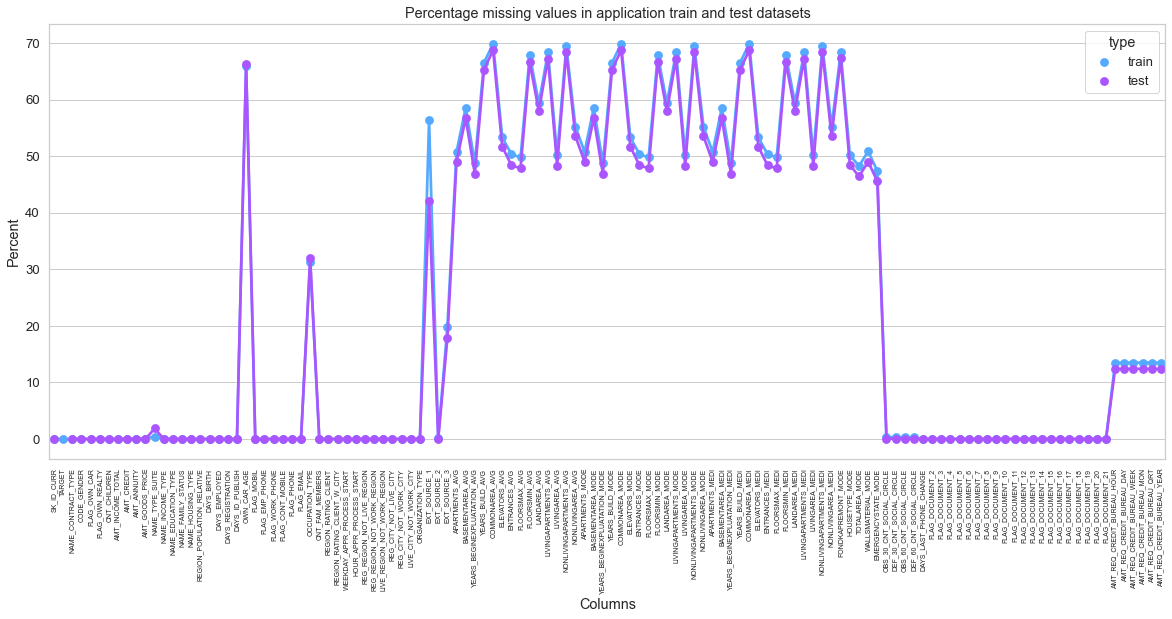

<IPython.core.display.Javascript object>

In [146]:
# Prep train-test data
miss_train = pd.DataFrame(
    (application_train.isnull().sum()) * 100 / application_train.shape[0]
).reset_index()
miss_test = pd.DataFrame(
    (application_test.isnull().sum()) * 100 / application_test.shape[0]
).reset_index()
miss_train["type"] = "train"
miss_test["type"] = "test"
missing = pd.concat([miss_train, miss_test], axis=0)

# Plot misssing data vs column
fig = plt.figure(figsize=(20, 8))
ax = sns.pointplot("index", 0, data=missing, hue="type", palette="cool")
plt.xticks(rotation=90, fontsize=7)
plt.title("Percentage missing values in application train and test datasets")
plt.ylabel("Percent")
_ = plt.xlabel("Columns")

As we can see from the above graph we many columns where we have missing values. We will have to fill in these missing values (known as imputation). In later work, we will use models such as XGBoost that can handle missing values with no need for imputation, but we also will use other models, which can not do that. Another option would be to drop columns with a high percentage of missing values, although it is impossible to know ahead of time if these columns will be helpful to our model. Therefore, we will keep all of the columns for now.

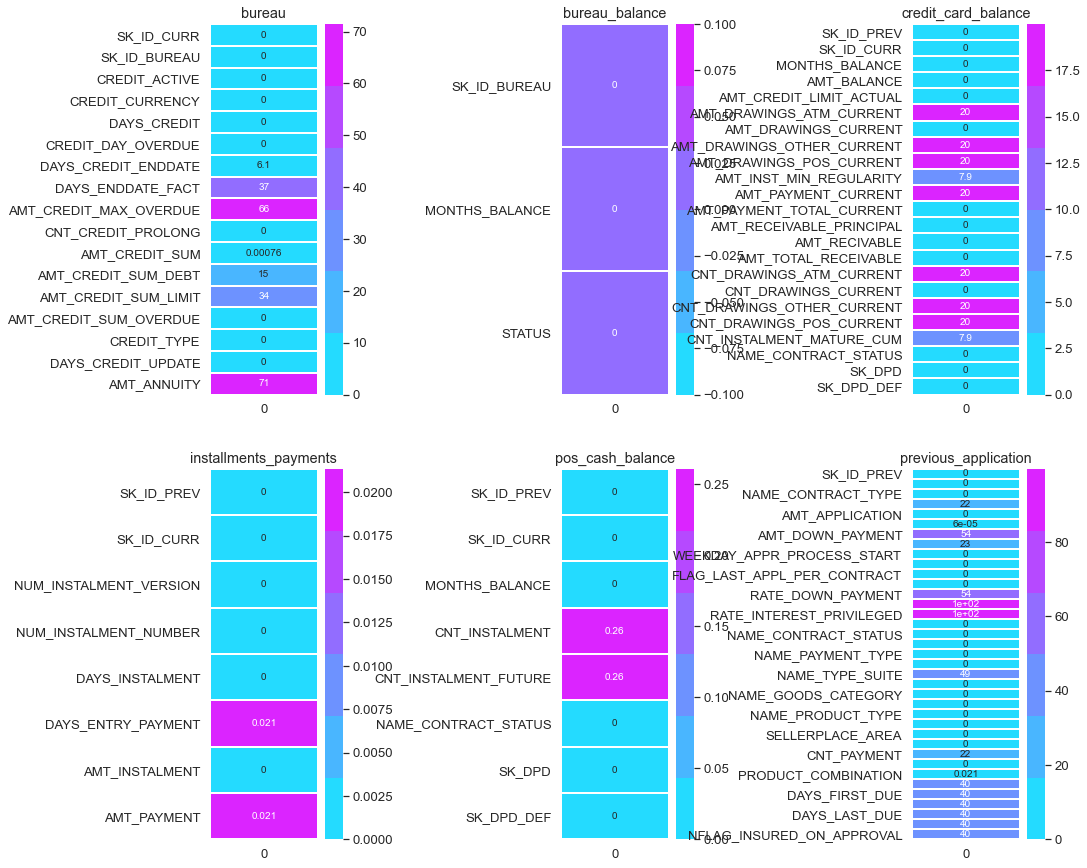

<IPython.core.display.Javascript object>

In [147]:
plt.figure(figsize=(15, 15))

# Bureau data
plt.subplot(231)
sns.heatmap(
    pd.DataFrame(bureau.isnull().sum() / bureau.shape[0] * 100),
    annot=True,
    cmap=sns.color_palette("cool"),
    linewidth=1,
    linecolor="white",
)
plt.title("bureau")

# Bureau balance data
plt.subplot(232)
sns.heatmap(
    pd.DataFrame(bureau_balance.isnull().sum() / bureau_balance.shape[0] * 100),
    annot=True,
    cmap=sns.color_palette("cool"),
    linewidth=1,
    linecolor="white",
)
plt.title("bureau_balance")

# Credit card balance
plt.subplot(233)
sns.heatmap(
    pd.DataFrame(
        credit_card_balance.isnull().sum() / credit_card_balance.shape[0] * 100
    ),
    annot=True,
    cmap=sns.color_palette("cool"),
    linewidth=1,
    linecolor="white",
)
plt.title("credit_card_balance")

# Installments payments
plt.subplot(234)
sns.heatmap(
    pd.DataFrame(
        installments_payments.isnull().sum() / installments_payments.shape[0] * 100
    ),
    annot=True,
    cmap=sns.color_palette("cool"),
    linewidth=1,
    linecolor="white",
)
plt.title("installments_payments")

# Cash balance
plt.subplot(235)
sns.heatmap(
    pd.DataFrame(pos_cash_balance.isnull().sum() / pos_cash_balance.shape[0] * 100),
    annot=True,
    cmap=sns.color_palette("cool"),
    linewidth=1,
    linecolor="white",
)
plt.title("pos_cash_balance")

# Previous Application
plt.subplot(236)
sns.heatmap(
    pd.DataFrame(
        previous_application.isnull().sum() / previous_application.shape[0] * 100
    ),
    annot=True,
    cmap=sns.color_palette("cool"),
    linewidth=1,
    linecolor="white",
)
plt.title("previous_application")

plt.subplots_adjust(wspace=1.6)

Looking at the other tables, also we have columns with missing data. Later on we will make some grouping methods and replace missing values.

# 3. Helper Functions

In [149]:
def plot_categorical_variables_bar(
    data: pd.DataFrame,
    column_name: str,
    figsize=(18, 6),
    percentage_display=True,
    plot_defaulter=True,
    rotation=0,
    horizontal_adjust=0,
    fontsize_percent="xx-small",
):

    """
    Function to plot Categorical Variables Bar Plots
    """

    print(
        f"Total Number of unique categories of {column_name} = {len(data[column_name].unique())}"
    )

    plt.figure(figsize=figsize, tight_layout=False)
    sns.set(style="whitegrid", font_scale=1.2)

    # plotting overall distribution of category
    plt.subplot(1, 2, 1)
    data_to_plot = data[column_name].value_counts().sort_values(ascending=False)
    ax = sns.barplot(x=data_to_plot.index, y=data_to_plot, palette="cool")

    if percentage_display:
        total_datapoints = len(data[column_name].dropna())
        for p in ax.patches:
            ax.text(
                p.get_x() + horizontal_adjust,
                p.get_height() + 0.005 * total_datapoints,
                "{:1.02f}%".format(p.get_height() * 100 / total_datapoints),
                fontsize=fontsize_percent,
            )

    plt.xlabel(column_name, labelpad=10)
    plt.title(f"Distribution of {column_name}", pad=20)
    plt.xticks(rotation=rotation)
    plt.ylabel("Counts")

    # plotting distribution of category for Defaulters
    if plot_defaulter:
        percentage_defaulter_per_category = (
            (
                data[column_name][data.TARGET == 1].value_counts()
                * 100
                / data[column_name].value_counts()
            )
            .dropna()
            .sort_values(ascending=False)
        )

        plt.subplot(1, 2, 2)
        sns.barplot(
            x=percentage_defaulter_per_category.index,
            y=percentage_defaulter_per_category,
            palette="cool",
        )
        plt.ylabel("Percentage of Defaulter per category")
        plt.xlabel(column_name, labelpad=10)
        plt.xticks(rotation=rotation)
        plt.title(
            f"Percentage of Defaulters for each category of {column_name}", pad=20
        )
    plt.show()

<IPython.core.display.Javascript object>

In [150]:
def plot_continuous_variables(
    data: pd.DataFrame,
    column_name: str,
    plots=["distplot", "box"],
    scale_limits=None,
    figsize=(20, 8),
    histogram=True,
    log_scale=False,
):

    """
    Function to plot continuous variables distribution
    """

    data_to_plot = data.copy()
    if scale_limits:
        # taking only the data within the specified limits
        data_to_plot[column_name] = data[column_name][
            (data[column_name] > scale_limits[0])
            & (data[column_name] < scale_limits[1])
        ]

    number_of_subplots = len(plots)
    plt.figure(figsize=figsize)
    sns.set_style("whitegrid")

    for i, ele in enumerate(plots):
        plt.subplot(1, number_of_subplots, i + 1)
        plt.subplots_adjust(wspace=0.25)

        if ele == "distplot":
            sns.distplot(
                data_to_plot[column_name][data["TARGET"] == 0].dropna(),
                label="Non-Defaulters",
                hist=False,
                color="red",
            )
            sns.distplot(
                data_to_plot[column_name][data["TARGET"] == 1].dropna(),
                label="Defaulters",
                hist=False,
                color="black",
            )
            plt.xlabel(column_name)
            plt.ylabel("Probability Density")
            plt.legend(fontsize="medium")
            plt.title("Dist-Plot of {}".format(column_name))
            if log_scale:
                plt.xscale("log")
                plt.xlabel(f"{column_name} (log scale)")

        if ele == "box":
            sns.boxplot(x="TARGET", y=column_name, data=data_to_plot, palette="cool")
            plt.title("Box-Plot of {}".format(column_name))
            if log_scale:
                plt.yscale("log")
                plt.ylabel(f"{column_name} (log Scale)")

    plt.show()

<IPython.core.display.Javascript object>

In [151]:
def plot_phik_matrix(
    data: pd.DataFrame,
    categorical_columns: pd.DataFrame,
    show_target_top_corr=True,
    target_top_columns=10,
):

    """
    Function to Phi_k matrix for categorical features
    """

    # first fetching only the categorical features
    data_for_phik = data[categorical_columns].astype("object")
    phik_matrix = data_for_phik.phik_matrix()
    if show_target_top_corr:
        # Seeing the top columns with highest correlation with the target variable in application_train
        print(
            "Categories with highest values of Phi-K Correlation value with Target Variable are:"
        )
        phik_df = pd.DataFrame(
            {
                "Column Name": phik_matrix.TARGET.index[1:],
                "Phik-Correlation": phik_matrix.TARGET.values[1:],
            }
        )
        phik_df = phik_df.sort_values(by="Phik-Correlation", ascending=False)
        display(phik_df.head(target_top_columns))

<IPython.core.display.Javascript object>

In [152]:
def target_top_corr(
    data: pd.DataFrame, columns_to_drop: pd.DataFrame, target_top_columns=10
):
    """
    Function to return the Top Correlated features with the Target.
    """
    corr_data = data.drop(columns_to_drop + ["TARGET"], axis=1).corr()

    phik_target_arr = np.zeros(corr_data.shape[1])
    # calculating the Phik-Correlation with Target
    for index, column in enumerate(corr_data.columns):
        phik_target_arr[index] = data[["TARGET", column]].phik_matrix().iloc[0, 1]
    # getting the top correlated columns and their values
    top_corr_target_df = pd.DataFrame(
        {"Column Name": corr_data.columns, "Phik-Correlation": phik_target_arr}
    )
    top_corr_target_df = top_corr_target_df.sort_values(
        by="Phik-Correlation", ascending=False
    )

    return top_corr_target_df.iloc[:target_top_columns]

<IPython.core.display.Javascript object>

In [153]:
def plot_algo_results(
    model,
    X_train: pd.DataFrame,
    y_train: pd.DataFrame,
    X_test: pd.DataFrame,
    y_test: pd.DataFrame,
):
    """
    Function to return the results of model peformance
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    cm = confusion_matrix(y_test, y_pred)
    rauc = metrics.roc_auc_score(y_test, y_prob)
    print(classification_report(y_test, y_pred))
    print(f"AUC score: {metrics.roc_auc_score(y_test, y_prob)}")
    print("Accuracy Score: ", accuracy_score(y_test, y_pred))
    # Visualizing the ROC-AUC curve
    false_positive_rate, true_positive_rate, thresholds = metrics.roc_curve(
        y_test, y_prob
    )
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

    sns.heatmap(
        cm,
        cmap="Blues",
        annot=True,
        fmt="d",
        linewidths=5,
        cbar=False,
        annot_kws={"fontsize": 15},
        yticklabels=["No risk", "Risk"],
        xticklabels=["Predicted no risk", "Predicted risk"],
        ax=ax1,
    )

    ax2.plot(
        false_positive_rate,
        true_positive_rate,
        color="#b01717",
        label="AUC = %0.4f" % rauc,
        # ax=ax2,
    )

    ax2.legend(loc="lower right")
    ax2.plot([0, 1], [0, 1], linestyle="--", color="#174ab0")
    ax2.axis("tight")  # to remove additional white space in the plot
    ax2.set_ylabel("True Positive Rate (Sensitivity)")
    ax2.set_xlabel("False Positive rate (1-Specificity)")
    ax2.legend()

    fig.tight_layout(pad=3.0)
    plt.show()

<IPython.core.display.Javascript object>

# 4. EDA
Exploratory Data Analysis (EDA) is an open-ended process where we calculate statistics and make figures to find trends, anomalies, patterns, or relationships within the data. The goal of EDA is to learn what our data can tell us. It generally starts out with a high level overview, then narrows in to specific areas as we find intriguing areas of the data. The findings may be interesting in their own right, or they can be used to inform our modeling choices, such as by helping us decide which features to use.

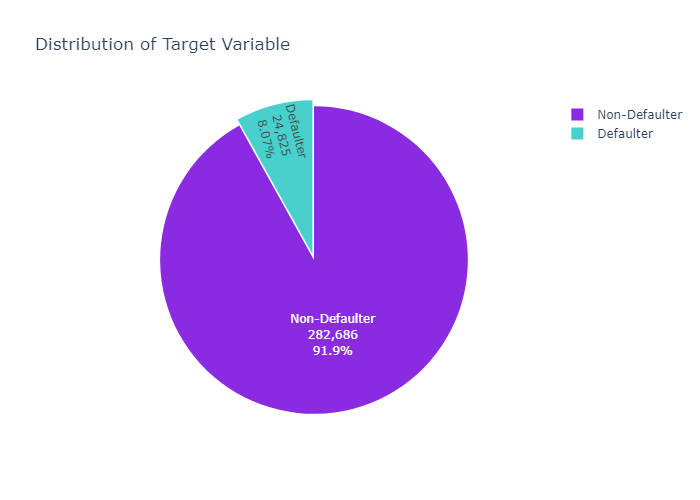

<IPython.core.display.Javascript object>

In [154]:
target_distribution = application_train.TARGET.value_counts()
labels = ["Non-Defaulter", "Defaulter"]
colors = ["#8A2BE2", "mediumturquoise"]


fig = go.Figure(
    data=[
        go.Pie(
            values=target_distribution,
            labels=labels,
            textinfo="label+percent+value",
            pull=[0, 0.04],
            marker=dict(colors=colors),
        )
    ],
    layout=go.Layout(title="Distribution of Target Variable"),
)

fig.show("png")

The target is what we are asked to predict: either a 0 for the loan was repaid on time, or a 1 indicating the client had payment difficulties. We can first examine the number of loans falling into each category.

From this information, we see this is an imbalanced class problem. There are far more loans that were repaid on time than loans that were not repaid. Once we get into more sophisticated machine learning models, we can weight the classes by their representation in the data to reflect this imbalance.

## 4.1. Correlations

For our EDA, we can look at correlation coefficients between features and the target. This gives us a more quantitative measure for the relationships we have just explored visually. Below we will see the most correlations.

In [15]:
categorical_columns = (
    [
        "TARGET",
        "FLAG_MOBIL",
        "FLAG_EMP_PHONE",
        "FLAG_WORK_PHONE",
        "FLAG_CONT_MOBILE",
        "FLAG_PHONE",
        "FLAG_EMAIL",
        "REGION_RATING_CLIENT",
        "REGION_RATING_CLIENT_W_CITY",
        "REG_REGION_NOT_LIVE_REGION",
        "REG_REGION_NOT_WORK_REGION",
        "LIVE_REGION_NOT_WORK_REGION",
        "REG_CITY_NOT_LIVE_CITY",
        "REG_CITY_NOT_WORK_CITY",
        "LIVE_CITY_NOT_WORK_CITY",
    ]
    + ["FLAG_DOCUMENT_" + str(i) for i in range(2, 22)]
    + application_train.dtypes[application_train.dtypes == "object"].index.tolist()
)
plot_phik_matrix(application_train, categorical_columns)

Categories with highest values of Phi-K Correlation value with Target Variable are:


,Column Name,Phik-Correlation
43,OCCUPATION_TYPE,0.1028
45,ORGANIZATION_TYPE,0.0892
39,NAME_INCOME_TYPE,0.0848
12,REG_CITY_NOT_WORK_CITY,0.0799
1,FLAG_EMP_PHONE,0.0721
11,REG_CITY_NOT_LIVE_CITY,0.0696
15,FLAG_DOCUMENT_3,0.0695
41,NAME_FAMILY_STATUS,0.0560
42,NAME_HOUSING_TYPE,0.0511
13,LIVE_CITY_NOT_WORK_CITY,0.0510


<IPython.core.display.Javascript object>

In [16]:
columns_to_drop = ["SK_ID_CURR"] + list(set(categorical_columns) - set(["TARGET"]))
corr_mat = target_top_corr(application_train, columns_to_drop)

interval columns not set, guessing: ['TARGET', 'CNT_CHILDREN']
interval columns not set, guessing: ['TARGET', 'AMT_INCOME_TOTAL']
interval columns not set, guessing: ['TARGET', 'AMT_CREDIT']
interval columns not set, guessing: ['TARGET', 'AMT_ANNUITY']
interval columns not set, guessing: ['TARGET', 'AMT_GOODS_PRICE']
interval columns not set, guessing: ['TARGET', 'REGION_POPULATION_RELATIVE']
interval columns not set, guessing: ['TARGET', 'DAYS_BIRTH']
interval columns not set, guessing: ['TARGET', 'DAYS_EMPLOYED']
interval columns not set, guessing: ['TARGET', 'DAYS_REGISTRATION']
interval columns not set, guessing: ['TARGET', 'DAYS_ID_PUBLISH']
interval columns not set, guessing: ['TARGET', 'OWN_CAR_AGE']
interval columns not set, guessing: ['TARGET', 'CNT_FAM_MEMBERS']
interval columns not set, guessing: ['TARGET', 'HOUR_APPR_PROCESS_START']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_1']
interval columns not set, guessing: ['TARGET', 'EXT_SOURCE_2']
interval columns 

<IPython.core.display.Javascript object>

In [17]:
# Seeing the top columns with highest phik-correlation with the target variable in application_train table
top_corr_target_df = corr_mat
print("Columns with highest values of Phik-correlation with Target Variable are:")
display(top_corr_target_df)

Columns with highest values of Phik-correlation with Target Variable are:


,Column Name,Phik-Correlation
15,EXT_SOURCE_3,0.2477
13,EXT_SOURCE_1,0.2178
14,EXT_SOURCE_2,0.2140
6,DAYS_BIRTH,0.1024
63,DAYS_LAST_PHONE_CHANGE,0.0732
7,DAYS_EMPLOYED,0.0721
9,DAYS_ID_PUBLISH,0.0678
4,AMT_GOODS_PRICE,0.0591
23,FLOORSMAX_AVG,0.0588
51,FLOORSMAX_MEDI,0.0586


<IPython.core.display.Javascript object>

This agrees with some of the insight we were able to pull from the visualisations. Target correlates perfectly with itself as expected. Then we can see that age has a strong positive correlation, which is actually reversed because age is negative.

We also see that the EXT_SOURCE variables do seem to hold some information that will help us predict the target class.

In [18]:
# desribe the categorical data
application_train.loc[:, application_train.dtypes == np.object].describe()

,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,NAME_TYPE_SUITE,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,OCCUPATION_TYPE,WEEKDAY_APPR_PROCESS_START,ORGANIZATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
count,307511,307511,307511,307511,306219,307511,307511,307511,307511,211120,307511,307511,97216,153214,151170,161756
unique,2,3,2,2,7,8,5,6,6,18,7,58,4,3,7,2
top,Cash loans,F,N,Y,Unaccompanied,Working,Secondary / secondary special,Married,House / apartment,Laborers,TUESDAY,Business Entity Type 3,reg oper account,block of flats,Panel,No
freq,278232,202448,202924,213312,248526,158774,218391,196432,272868,55186,53901,67992,73830,150503,66040,159428


<IPython.core.display.Javascript object>

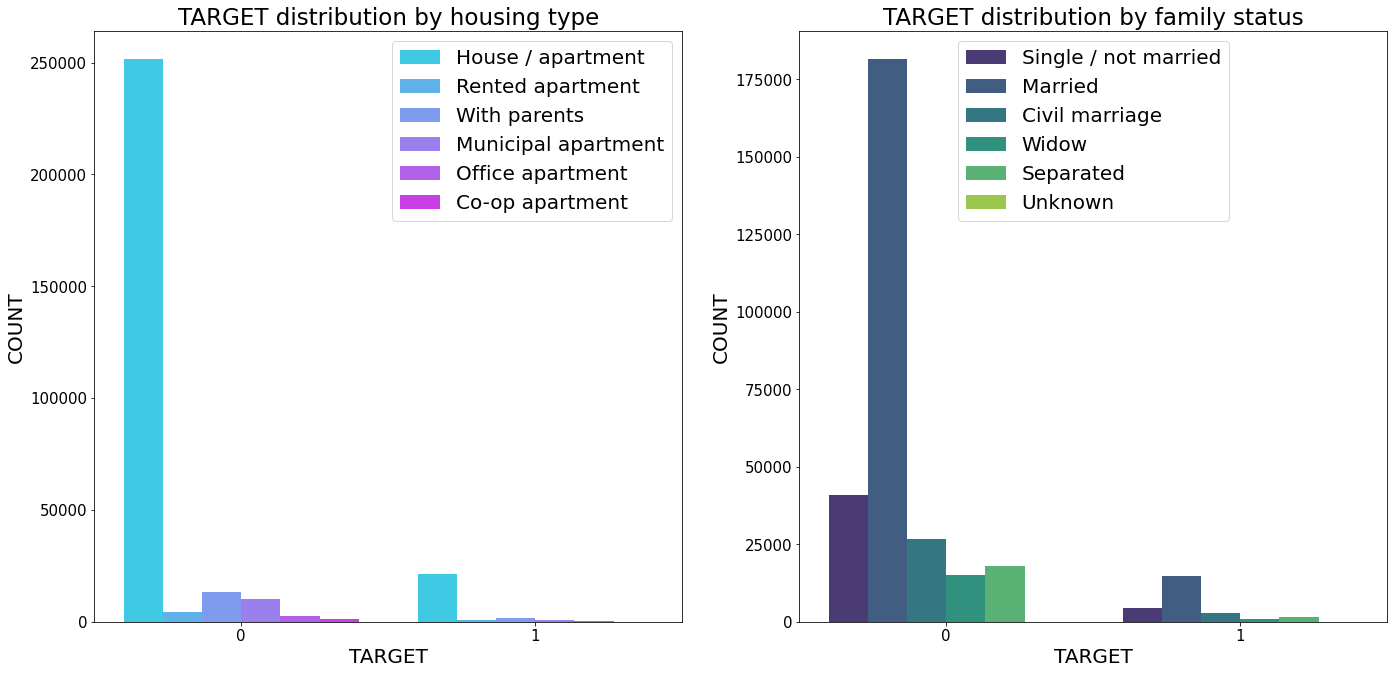

<IPython.core.display.Javascript object>

In [21]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

sns.countplot(
    data=application_train, x="TARGET", hue="NAME_HOUSING_TYPE", palette="cool", ax=ax1
)
ax1.set_title("TARGET distribution by housing type", fontdict={"fontsize": 23})
ax1.set_xlabel("TARGET", fontsize=20)
ax1.set_ylabel("COUNT", fontsize=20)
ax1.legend(prop={"size": 20})
ax1.tick_params(labelsize=15)

sns.countplot(
    data=application_train,
    x="TARGET",
    hue="NAME_FAMILY_STATUS",
    ax=ax2,
    palette="viridis",
)
ax2.set_title("TARGET distribution by family status", fontdict={"fontsize": 23})
ax2.set_xlabel("TARGET", fontsize=20)
ax2.set_ylabel("COUNT", fontsize=20)
ax2.legend(prop={"size": 20})
ax2.tick_params(labelsize=15)

fig.tight_layout(pad=3.0)
plt.show()

From the first subplot:
- Mostly people have house or apartament. 
- As we can see that this type is also for defaulter as major.

From the second subplot:
- Talking about family status it seems that we do not have any suspiciuos, a bigger part of people who are taking loans are married.

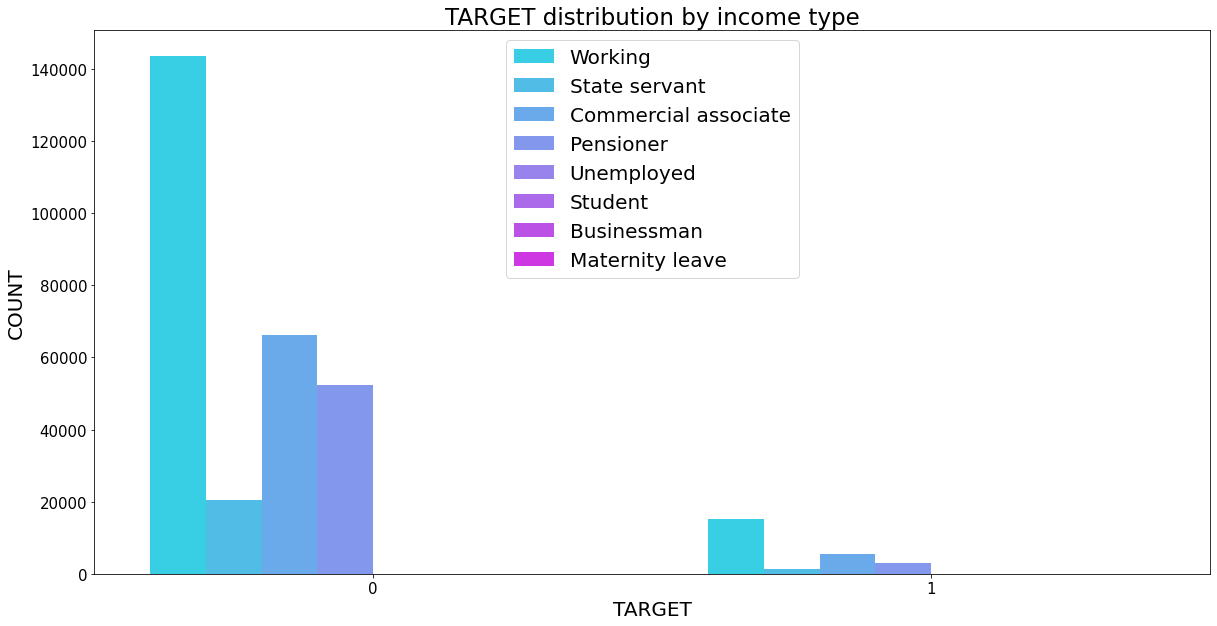

<IPython.core.display.Javascript object>

In [22]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(20, 10))

sns.countplot(
    data=application_train, x="TARGET", hue="NAME_INCOME_TYPE", palette="cool", ax=ax1
)
ax1.set_title("TARGET distribution by income type", fontdict={"fontsize": 23})
ax1.set_xlabel("TARGET", fontsize=20)
ax1.set_ylabel("COUNT", fontsize=20)
ax1.legend(prop={"size": 20})
ax1.tick_params(labelsize=15)
plt.show()

From the plot:
- we can see that mostly working people are taking loans 
- Second note is that in the dataset we have small amount of students or pensioners.

Total Number of unique categories of OCCUPATION_TYPE = 19


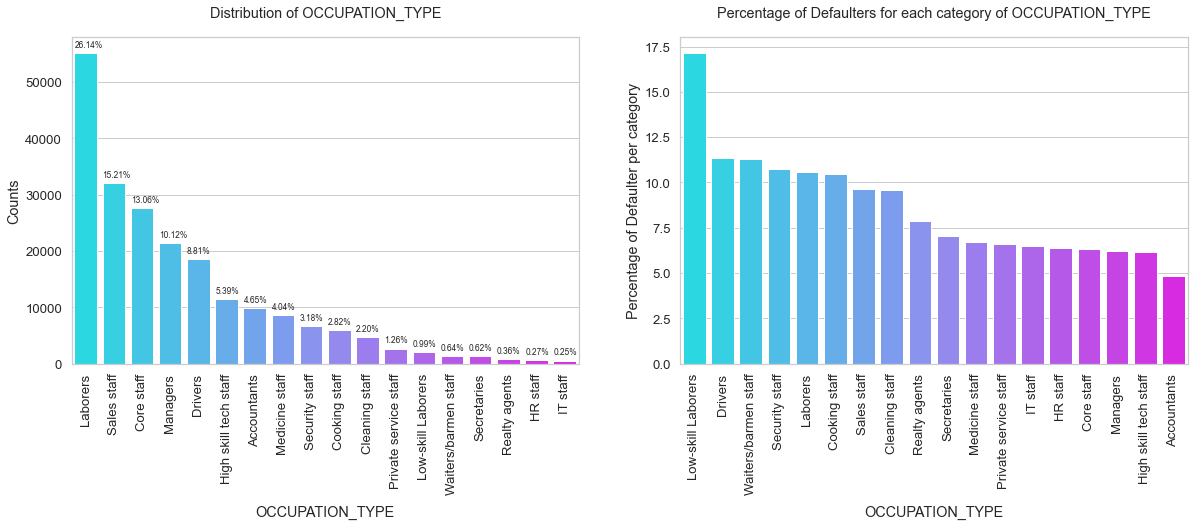

<IPython.core.display.Javascript object>

In [23]:
# plotting the Bar Plot for the Column
plot_categorical_variables_bar(
    application_train, column_name="OCCUPATION_TYPE", figsize=(20, 6), rotation=90
)

From the first subplot:
- Among the applicants, the most common type of Occupation is Laborers contributing to close to 26% applications. 
- The next most frequent occupation is Sales Staff, followed by Core Staff and Managers.

From the second subplot:
- The Defaulting Rate for Low-Skill Laborers is the highest among all the occupation types (~17.5%). 
- This is followed by Drivers, Waiters, Security Staff, Laborers, Cooking Staff. All the jobs are low-level jobs.
- This shows that low-level Jobs people tend to have higher default rate.
- The lowest Defaulting Rate are among Accountants, Core Staff, Managers, High skill tech staff, HR staff, etc. which are from medium to high level jobs.

Thus it can be concluded that Low-level job workers tend to have a higher defaulting tendency compared to medium-high level jobs.

### Statistics inferences

In this part we will write a statistics inference to find out if there is a significant difference between two groups.

###### Significance testing:

With significance testing task I would like to test: Whether there is a significance ( confidence 95%) difference in two groups

control group: the mean of credit who are Low-skill Laborers and defaulter.

experiment group: the mean of credit who are Laborers and non defaulter.

##### Hypothesis: H(0): There is no diference between the control and experiment groups

Ho: μ1 = μ2

##### H(a): We do not know whether experimental group will do better or not.

Ha: μ1 ≠ μ2

In [24]:
control_group = application_train.loc[
    (application_train.OCCUPATION_TYPE == "Low-skill Laborers")
    & (application_train.TARGET == 1)
][["AMT_CREDIT"]]
experiment_group = application_train.loc[
    (application_train.OCCUPATION_TYPE == "Laborers") & (application_train.TARGET == 0)
][["AMT_CREDIT"]]

<IPython.core.display.Javascript object>

In [25]:
print(f"{control_group.describe()}, \n\n{experiment_group.describe()}")

        AMT_CREDIT
count     359.0000
mean   434290.6880
std    250628.7684
min     47970.0000
25%    251280.0000
50%    383202.0000
75%    545040.0000
max   1506816.0000, 

        AMT_CREDIT
count   49348.0000
mean   575075.3386
std    379819.4043
min     45000.0000
25%    270000.0000
50%    495216.0000
75%    790830.0000
max   2925000.0000


<IPython.core.display.Javascript object>

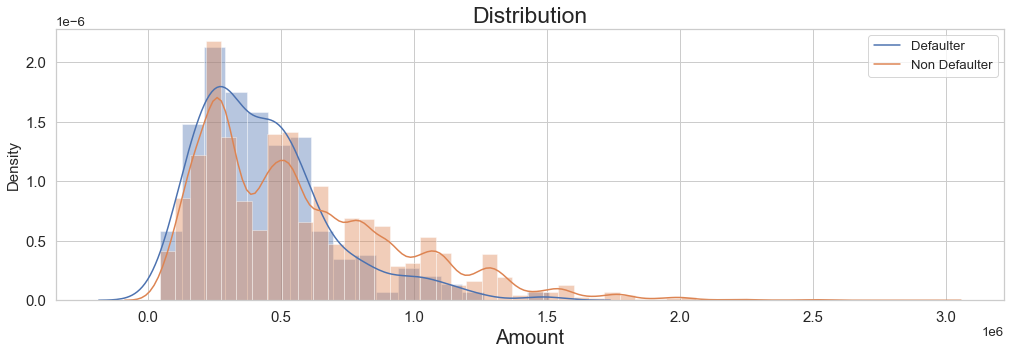

<IPython.core.display.Javascript object>

In [26]:
fig, ax = plt.subplots(figsize=(17, 5))
targets = [
    "Defaulter",
    "Non Defaulter",
]
sns.distplot(control_group["AMT_CREDIT"])
sns.distplot(experiment_group["AMT_CREDIT"])
ax.legend(targets)
plt.title("Distribution", fontsize=23)
plt.xlabel("Amount", fontsize=20)
plt.ylabel("Density", fontsize=15)
plt.tick_params(labelsize=15)
plt.show()

#### Insights

- we can see how differently distributed the amount of these two different group.

In [27]:
ALPHA = 0.05

t, p = stats.ttest_ind(
    control_group["AMT_CREDIT"],
    experiment_group["AMT_CREDIT"],
    equal_var=False,
)
t, p = np.round(t, 5), np.round(p, 5)

if p <= ALPHA:
    print(
        f"Since p = {p} < {ALPHA}, reject H0, different mean distributions between two groups (t={t}, p={p})"
    )
else:
    print(
        f"Since p = {p} > {ALPHA}, fail to reject H0, same mean distributions between two groups (t={t}, p={p})."
    )

Since p = 0.0 < 0.05, reject H0, different mean distributions between two groups (t=-10.55537, p=0.0)


<IPython.core.display.Javascript object>

#### Insights

From our statistics we can reject our H0, because our method show us, that we have significant difference between these two groups. 

Total Number of categories of ORGANIZATION_TYPE = 58


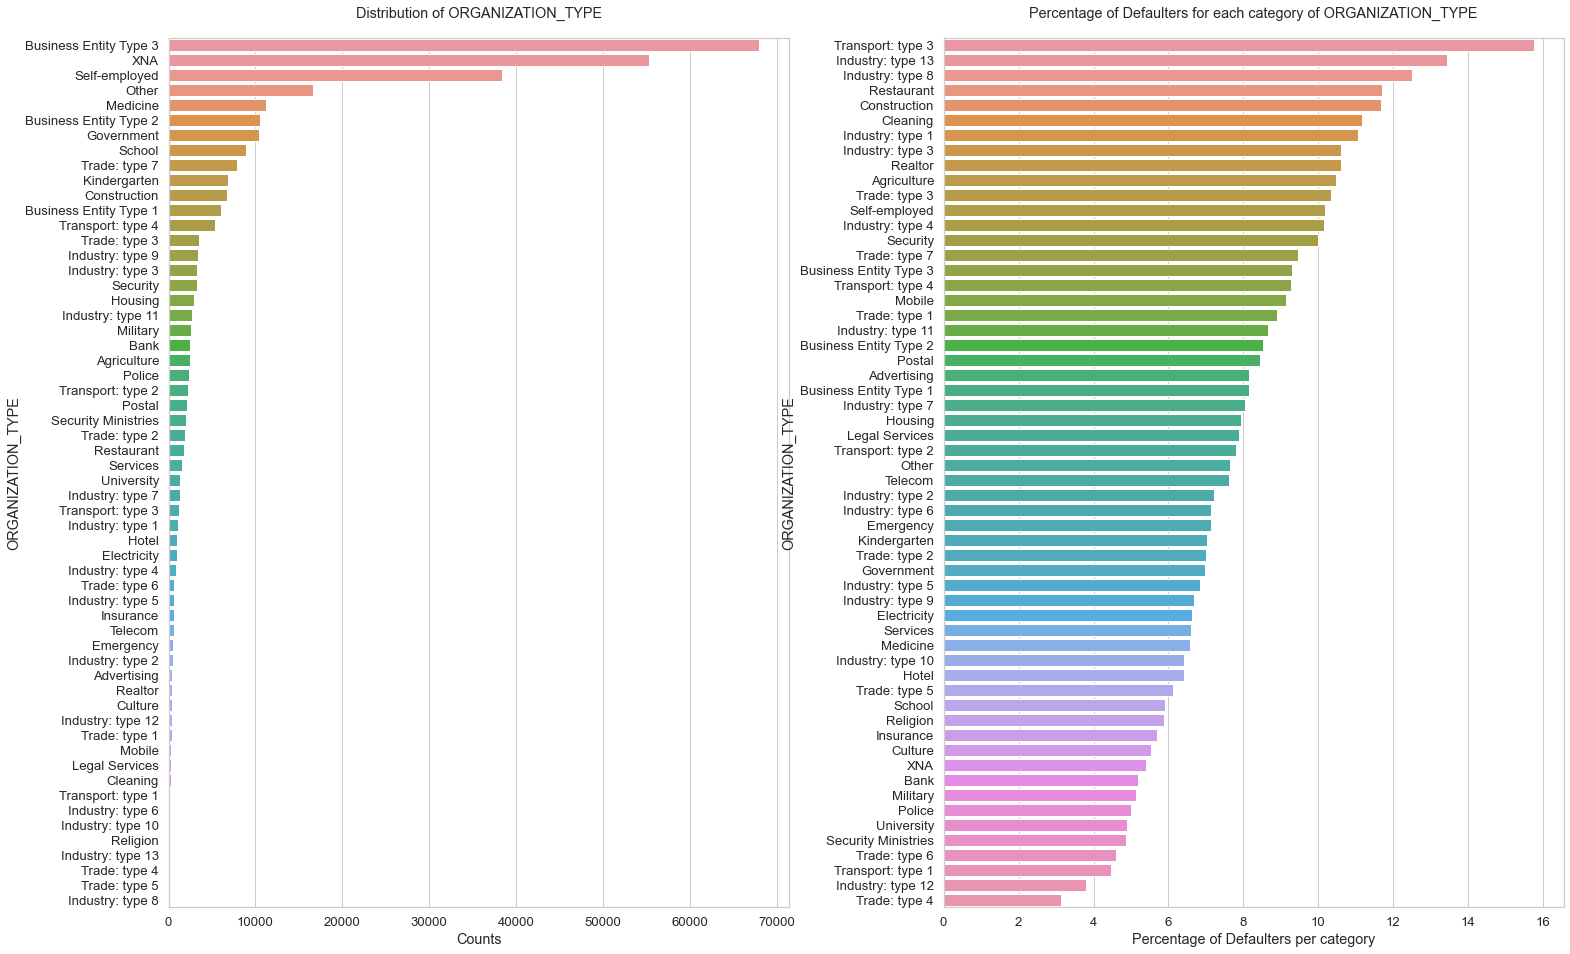

<IPython.core.display.Javascript object>

In [28]:
print(
    f"Total Number of categories of ORGANIZATION_TYPE = {len(application_train.ORGANIZATION_TYPE.unique())}"
)

plt.figure(figsize=(25, 16))
sns.set(style="whitegrid", font_scale=1.2)
plt.subplots_adjust(wspace=0.25)

plt.subplot(1, 2, 1)
count_organization = application_train.ORGANIZATION_TYPE.value_counts().sort_values(
    ascending=False
)
sns.barplot(x=count_organization, y=count_organization.index)
plt.title("Distribution of ORGANIZATION_TYPE", pad=20)
plt.xlabel("Counts")
plt.ylabel("ORGANIZATION_TYPE")

plt.subplot(1, 2, 2)
percentage_default_per_organization = (
    application_train[application_train.TARGET == 1].ORGANIZATION_TYPE.value_counts()
    * 100
    / count_organization
)
percentage_default_per_organization = (
    percentage_default_per_organization.dropna().sort_values(ascending=False)
)
sns.barplot(
    x=percentage_default_per_organization, y=percentage_default_per_organization.index
)
plt.title("Percentage of Defaulters for each category of ORGANIZATION_TYPE", pad=20)
plt.xlabel("Percentage of Defaulters per category")
plt.ylabel("ORGANIZATION_TYPE")

plt.show()

From the first subplot:
- We see that most of the applicants work in Organizations of Type 'Business Entity Type3', 'XNA' or 'Self Employed'. 
- The Organization Type 'XNA' could probably denote unclassified Organization TYpe.

From the second subplot:
- We notice that the applicants belonging to 'Transport: type 3' have the highest defaulting tendency as compared to the rest.

Total Number of unique categories of FLAG_DOCUMENT_3 = 2


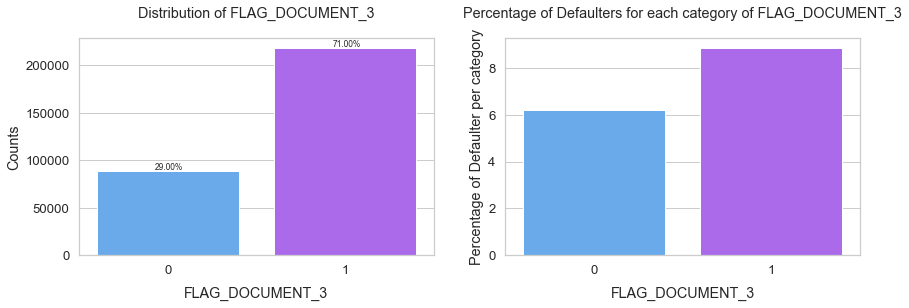

<IPython.core.display.Javascript object>

In [29]:
plot_categorical_variables_bar(
    application_train,
    column_name="FLAG_DOCUMENT_3",
    figsize=(14, 4),
    horizontal_adjust=0.33,
)

From the first subplot:
- We see that most of the clients provided this document (~71%) and only 29% did not.

From the second subplot:
- We see that those who had provided this document had a higher defaulting rate than those who didn't. This means that the applicants who had provided the Document_3 tend to default more than those who don't.

Total Number of unique categories of FLAG_EMP_PHONE = 2


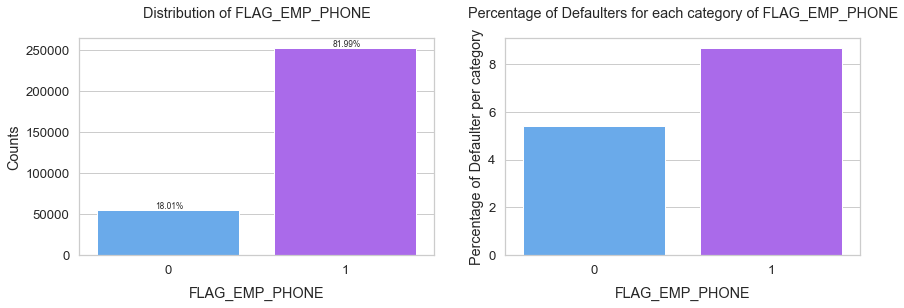

<IPython.core.display.Javascript object>

In [30]:
plot_categorical_variables_bar(
    application_train,
    column_name="FLAG_EMP_PHONE",
    figsize=(14, 4),
    horizontal_adjust=0.33,
)

From the first subplot:
- We see that most of the clients provided their work phone number (~82%) and only 18% did not.

From the second subplot:
- We see that those who had provided this number had a higher defaulting rate than those who didn't. 

Total Number of unique categories of REG_CITY_NOT_LIVE_CITY = 2


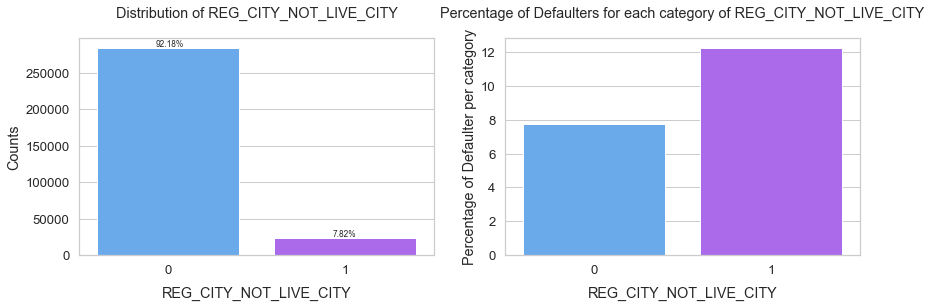

Total Number of unique categories of REG_CITY_NOT_WORK_CITY = 2


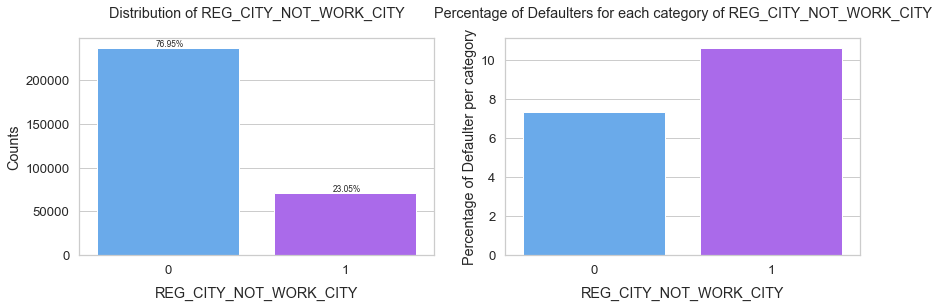

Total Number of unique categories of LIVE_CITY_NOT_WORK_CITY = 2


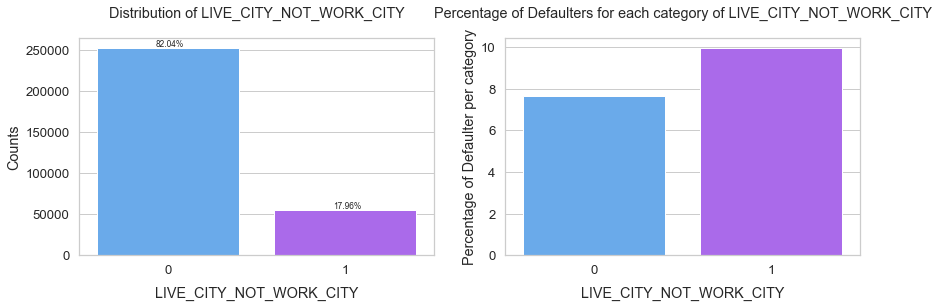

<IPython.core.display.Javascript object>

In [31]:
plot_categorical_variables_bar(
    application_train,
    column_name="REG_CITY_NOT_LIVE_CITY",
    figsize=(14, 4),
    horizontal_adjust=0.33,
)
plot_categorical_variables_bar(
    application_train,
    column_name="REG_CITY_NOT_WORK_CITY",
    figsize=(14, 4),
    horizontal_adjust=0.33,
)
plot_categorical_variables_bar(
    application_train,
    column_name="LIVE_CITY_NOT_WORK_CITY",
    figsize=(14, 4),
    horizontal_adjust=0.33,
)

- Firstly, there are only ~7% people who have different permanent address from their contact address at region level.
- Secondly, there are around 23.05% people who have different permanent address from their work address at region level. This higher number is explainable, because it is possible that they work in different region as compared to their permanent address.
- Lastly, there are around 18% people who have different permanent address from their contact address at city level.

If we look at the defaulting characteristics, we find that there is maximum defaulting tendency of those people who have their permanent and contact addresses different at region level, which is followed by different permanent and work address and lastly different permanent and contact address at city level.

For all the cases it is seen that the Defaulting tendency of those people who have different addresses is higher than those who have same address. This means that somewhere, this difference in address may suggest Defaulting Risk.

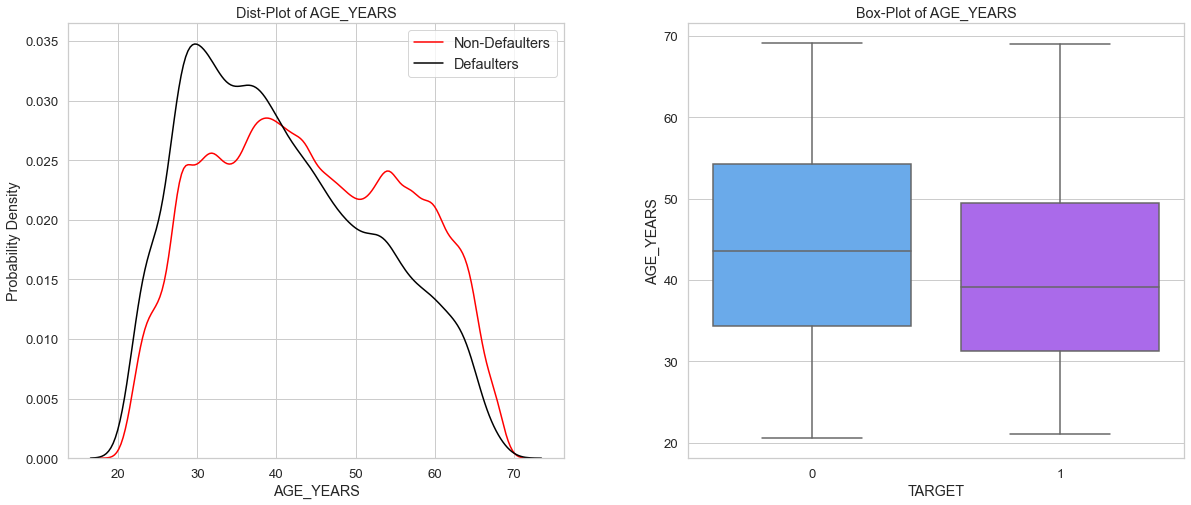

<IPython.core.display.Javascript object>

In [32]:
application_train["AGE_YEARS"] = application_train["DAYS_BIRTH"] * -1 / 365
plot_continuous_variables(application_train, "AGE_YEARS", plots=["distplot", "box"])
application_test["AGE_YEARS"] = application_test["DAYS_BIRTH"] * -1 / 365

- From the distplot, we can observe the peak of Age of people who Default to be close to 30 years. Also, at this point, the Non-Defaulters have a quite smaller PDF. One more thing to note is that the PDF of Age for Defaulters starts a bit left from the Non-Defaulters, and also is a bit throughtout the range. This means that the Defaulters are usually younger than Non-Defaulters.
- From the box-plot too, we can better visualize the same thing. The Age of Defaulters is usually lesser than the Non-Defaulters. All the quantiles of ages of Defaulters is lesser than Non-Defaulters. The 75th percentile value of Non-Defaulters is around 54 years while for Defaulters it is near to 49 years.

These observations imply that the Defaulters are usually younger than Non-Defaulters.

## Statistics inferences

In this part we will write a statistics inference to find out if there is a significant difference between two groups.

###### Significance testing:

With significance testing task I would like to test: Whether there is a significance ( confidence 95%) difference in two groups

control group: the mean of defaulter age.

experiment group: the mean of non-defaulter age.

##### Hypothesis: H(0): There is no diference between the control and experiment groups

Ho: μ1 = μ2

##### H(a): We do not know whether experimental group will do better or not.

Ha: μ1 ≠ μ2

In [33]:
control_group = application_train.loc[(application_train.TARGET == 1)][["AGE_YEARS"]]
experiment_group = application_train.loc[(application_train.TARGET == 0)][["AGE_YEARS"]]

<IPython.core.display.Javascript object>

In [34]:
print(f"{control_group.describe()}, \n\n{experiment_group.describe()}")

       AGE_YEARS
count 24825.0000
mean     40.7804
std      11.4872
min      21.0356
25%      31.2219
50%      39.1288
75%      49.4164
max      68.9534, 

        AGE_YEARS
count 282686.0000
mean      44.2142
std       11.9567
min       20.5178
25%       34.3452
50%       43.4986
75%       54.2295
max       69.1205


<IPython.core.display.Javascript object>

In [35]:
ALPHA = 0.05

t, p = stats.ttest_ind(
    control_group["AGE_YEARS"],
    experiment_group["AGE_YEARS"],
    equal_var=False,
)
t, p = np.round(t, 5), np.round(p, 5)

if p <= ALPHA:
    print(
        f"Since p = {p} < {ALPHA}, reject H0, different mean distributions between two groups (t={t}, p={p})"
    )
else:
    print(
        f"Since p = {p} > {ALPHA}, fail to reject H0, same mean distributions between two groups (t={t}, p={p})."
    )

Since p = 0.0 < 0.05, reject H0, different mean distributions between two groups (t=-45.00619, p=0.0)


<IPython.core.display.Javascript object>

#### Insights

From our statistics we can reject our H0, because our method show us, that we have significant difference between these two groups. 

count   307511.0000
mean     63815.0459
std     141275.7665
min     -17912.0000
25%      -2760.0000
50%      -1213.0000
75%       -289.0000
max     365243.0000
Name: DAYS_EMPLOYED, dtype: float64


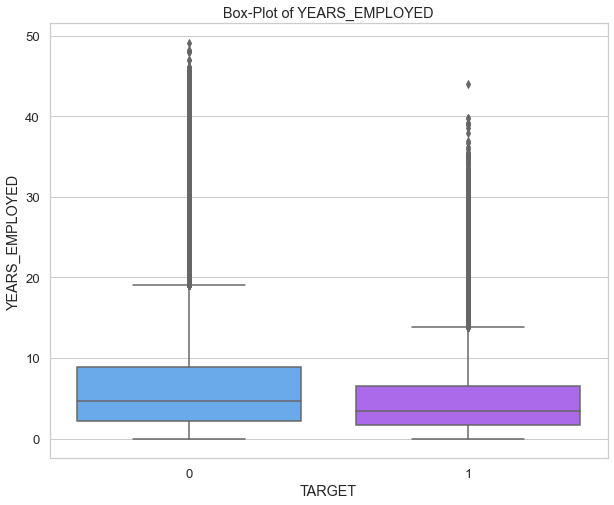

<IPython.core.display.Javascript object>

In [36]:
application_train["YEARS_EMPLOYED"] = application_train.DAYS_EMPLOYED * -1 / 365
print(application_train.DAYS_EMPLOYED.describe())
plot_continuous_variables(
    application_train,
    "YEARS_EMPLOYED",
    plots=["box"],
    scale_limits=[0, 70],
    figsize=(10, 8),
)
_ = application_train.pop("YEARS_EMPLOYED")

- We see that the DAYS_EMPLOYED column contains some erroneous datapoints with values 365243. These seem like some erroneous/non-sensicle values.
- From the box plot we observe that the Defaulters seem to have less number of years being employed as compared to Non-Defaulters. All the 25th, 50th and 75th quantile for Defaulters are lesser than those of Non-Defaulters.

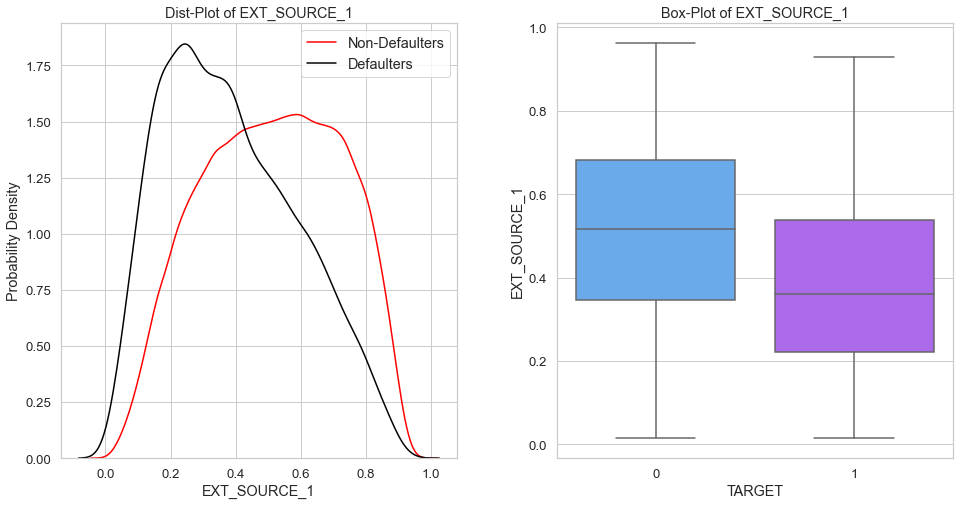

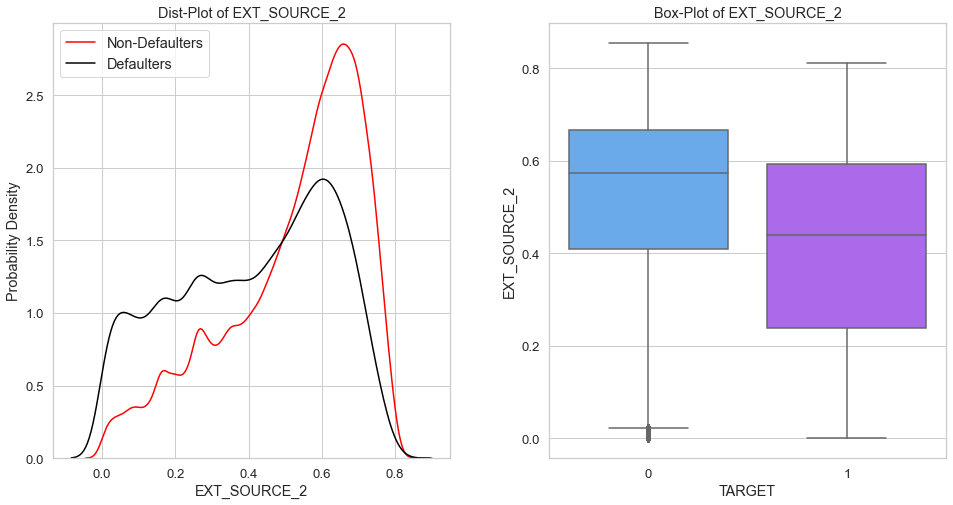

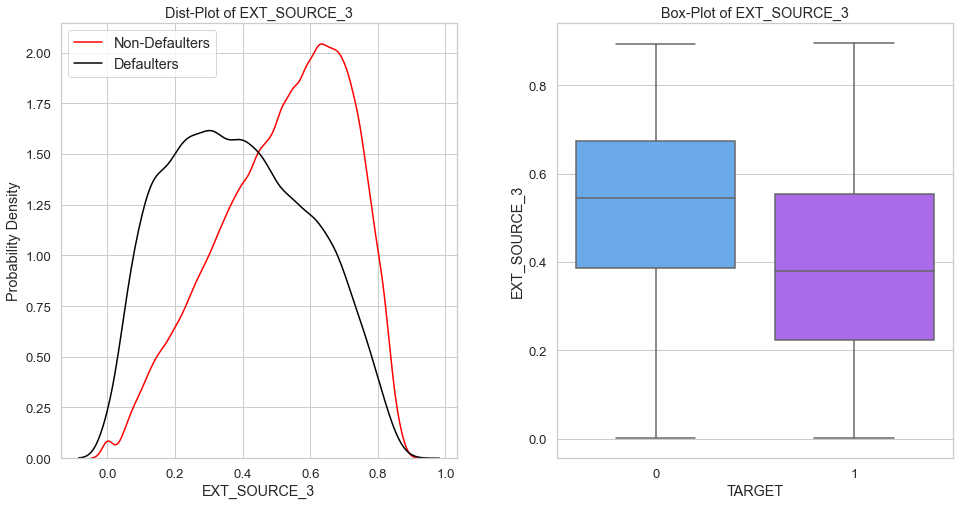

<IPython.core.display.Javascript object>

In [37]:
plot_continuous_variables(
    application_train, "EXT_SOURCE_1", plots=["distplot", "box"], figsize=(16, 8)
)
plot_continuous_variables(
    application_train, "EXT_SOURCE_2", plots=["distplot", "box"], figsize=(16, 8)
)
plot_continuous_variables(
    application_train, "EXT_SOURCE_3", plots=["distplot", "box"], figsize=(16, 8)
)

- If we look at the box-plots, we can clearly see a similar trend for all three EXT_SOURCE columns, which is that the Defaulters tend to have considerably lower values.
- The Non-Defaulters show a higher peak at high EXT_SOURCE values, and the Probability Densities are very low for low values. This implies that Non-Defaulters generally have high values of these scores.
.
These 3 features look to be best separating the Defaulters and Non-Defaulters linearly among all the features so far.

**We can conclude the above data analysis:**

1. Firstly, the tables application_train.csv and application_test.csv will be needed to be merged with the extra tables.
2. Some categories are very well discriminatory between the Defaulters and Non-Defaulters, for example OCCUPATION_TYPE, ORGANIZATION_TYPE, REG_CITY_NOT_WORK_CITY, which could prove to be important for the classification purpose. The same goes for some Continuous features as well, noticeably the EXT_SOURCE_1, EXT_SOURCE_2, EXT_SOURCE_3 features.
3. There are few Continuous Numerical Variables which contain Erroneous points, such as DAYS_FIRST_DUE, DAYS_EMPLOYED, etc., which would need to be handled during Data Cleaning.
4. The dataset is imbalanced, and we would need to come up with techniques to handle it.

# 5. Data Cleaning and Feature Engineering
We know that we have train and test datasets as major ones, but also we have another datasets, from which we could make additional features to improve our solution even better. So in the next section we will try different datasets to clean, make new features for them and everything combine in one large dataset.

### 5.1.1. bureau_balance.csv and bureau.csv
These tables contain the information related to the client's previous credits which were not with Home Credit Group, and were reported by Credit Bureau Department.

In [38]:
bureau_balance.head(3)

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5715448,0,C
1,5715448,-1,C
2,5715448,-2,C


<IPython.core.display.Javascript object>

In [39]:
# encoding features
le = LabelEncoder()
bureau_balance["STATUS"] = le.fit_transform(bureau_balance["STATUS"])

# fixing months_balance feature
bureau_balance["MONTHS_BALANCE"] = np.abs(bureau_balance["MONTHS_BALANCE"])
bureau_balance["MONTHS_BALANCE"] = bureau_balance["MONTHS_BALANCE"] // 12

# aggregating over whole dataset first
aggregated_bureau_balance = (
    bureau_balance.groupby(["SK_ID_BUREAU"]).mean().reset_index()
)

# filling the missing values obtained after aggregatios with 0
aggregated_bureau_balance.fillna(0, inplace=True)

<IPython.core.display.Javascript object>

In [40]:
aggregated_bureau_balance = aggregated_bureau_balance.rename(
    columns={"SK_ID_BUREAU_": "SK_ID_BUREAU"}
)

<IPython.core.display.Javascript object>

In [41]:
aggregated_bureau_balance.head()

,SK_ID_BUREAU,MONTHS_BALANCE,STATUS
0,5001709,3.5464,6.1134
1,5001710,2.9639,6.0000
2,5001711,0.0000,1.7500
3,5001712,0.3684,2.8421
4,5001713,0.4545,7.0000


<IPython.core.display.Javascript object>

Another dataset, let's qucly check the info about features.

In [42]:
bureau.describe()

,SK_ID_CURR,SK_ID_BUREAU,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
count,1716428.0000,1716428.0000,1716428.0000,1716428.0000,1610875.0000,1082775.0000,591940.0000,1716428.0000,1716415.0000,1458759.0000,1124648.0000,1716428.0000,1716428.0000,489637.0000
mean,278214.9336,5924434.4890,-1142.1077,0.8182,510.5174,-1017.4371,3825.4177,0.0064,354994.5919,137085.1200,6229.5150,37.9128,-593.7483,15712.7577
std,102938.5581,532265.7286,795.1649,36.5444,4994.2198,714.0106,206031.6062,0.0962,1149811.3440,677401.1310,45032.0315,5937.6500,720.7473,325826.9491
min,100001.0000,5000000.0000,-2922.0000,0.0000,-42060.0000,-42023.0000,0.0000,0.0000,0.0000,-4705600.3200,-586406.1150,0.0000,-41947.0000,0.0000
25%,188866.7500,5463953.7500,-1666.0000,0.0000,-1138.0000,-1489.0000,0.0000,0.0000,51300.0000,0.0000,0.0000,0.0000,-908.0000,0.0000
50%,278055.0000,5926303.5000,-987.0000,0.0000,-330.0000,-897.0000,0.0000,0.0000,125518.5000,0.0000,0.0000,0.0000,-395.0000,0.0000
75%,367426.0000,6385681.2500,-474.0000,0.0000,474.0000,-425.0000,0.0000,0.0000,315000.0000,40153.5000,0.0000,0.0000,-33.0000,13500.0000
max,456255.0000,6843457.0000,0.0000,2792.0000,31199.0000,0.0000,115987185.0000,9.0000,585000000.0000,170100000.0000,4705600.3200,3756681.0000,372.0000,118453423.5000


<IPython.core.display.Javascript object>

In [43]:
# merging it with aggregated bureau_balance on 'SK_ID_BUREAU'
bureau_merged = bureau.merge(aggregated_bureau_balance, on="SK_ID_BUREAU", how="left")

# from the describe table we saw some erroneous values in DAYS Fields, we will remove those
# we will only keep those loans which have ended in past 50 years.
bureau_merged["DAYS_CREDIT_ENDDATE"][
    bureau_merged["DAYS_CREDIT_ENDDATE"] > -50 * 365
] = np.nan
bureau_merged["DAYS_ENDDATE_FACT"][
    bureau_merged["DAYS_ENDDATE_FACT"] > -50 * 365
] = np.nan
# there is also a feature which tells about the number of days ago the Credit Report Came
bureau_merged["DAYS_CREDIT_UPDATE"][
    bureau_merged["DAYS_CREDIT_UPDATE"] > -50 * 365
] = np.nan

# engineering some features based on domain knowledge
bureau_merged["CREDIT_DURATION"] = np.abs(
    bureau_merged["DAYS_CREDIT"] - bureau_merged["DAYS_CREDIT_ENDDATE"]
)

bureau_merged["CURRENT_CREDIT_DEBT_DIFF"] = (
    bureau_merged["AMT_CREDIT_SUM"] - bureau_merged["AMT_CREDIT_SUM_DEBT"]
)

bureau_merged["CREDIT_ENDDATE_UPDATE_DIFF"] = np.abs(
    bureau_merged["DAYS_CREDIT_UPDATE"] - bureau_merged["DAYS_CREDIT_ENDDATE"]
)
bureau_merged["CURRENT_DEBT_TO_CREDIT_RATIO"] = bureau_merged["AMT_CREDIT_SUM_DEBT"] / (
    bureau_merged["AMT_CREDIT_SUM"] + 0.00001
)
bureau_merged["AMT_ANNUITY_CREDIT_RATIO"] = bureau_merged["AMT_ANNUITY"] / (
    bureau_merged["AMT_CREDIT_SUM"] + 0.00001
)

<IPython.core.display.Javascript object>

In [44]:
le = LabelEncoder()
bureau_merged["CREDIT_CURRENCY"] = le.fit_transform(bureau_merged["CREDIT_CURRENCY"])

<IPython.core.display.Javascript object>

In [45]:
# Encoding the categorical columns in one-hot form
credit_active_ohe = pd.get_dummies(
    bureau_merged["CREDIT_ACTIVE"], prefix="CREDIT_ACTIVE"
)
credit_type_ohe = pd.get_dummies(bureau_merged["CREDIT_TYPE"], prefix="CREDIT_TYPE")

# merging the encoded columns
bureau_merged = pd.concat(
    [
        bureau_merged.drop(["CREDIT_ACTIVE", "CREDIT_TYPE"], axis=1),
        credit_active_ohe,
        credit_type_ohe,
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [46]:
# aggregating the bureau_merged over all the columns
bureau_merged_aggregated = bureau_merged.groupby("SK_ID_CURR").agg("mean").reset_index()

<IPython.core.display.Javascript object>

In [47]:
bureau_merged_aggregated.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,DAYS_CREDIT_UPDATE,AMT_ANNUITY,MONTHS_BALANCE,STATUS,CREDIT_DURATION,CURRENT_CREDIT_DEBT_DIFF,CREDIT_ENDDATE_UPDATE_DIFF,CURRENT_DEBT_TO_CREDIT_RATIO,AMT_ANNUITY_CREDIT_RATIO,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Bad debt,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_TYPE_Another type of loan,CREDIT_TYPE_Car loan,CREDIT_TYPE_Cash loan (non-earmarked),CREDIT_TYPE_Consumer credit,CREDIT_TYPE_Credit card,CREDIT_TYPE_Interbank credit,CREDIT_TYPE_Loan for business development,CREDIT_TYPE_Loan for purchase of shares (margin lending),CREDIT_TYPE_Loan for the purchase of equipment,CREDIT_TYPE_Loan for working capital replenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mobile operator loan,CREDIT_TYPE_Mortgage,CREDIT_TYPE_Real estate loan,CREDIT_TYPE_Unknown type of loan
0,100001,5896633.0000,0.0000,-735.0000,0.0000,nan,nan,nan,0.0000,207623.5714,85240.9286,0.0000,0.0000,nan,3545.3571,0.6254,4.1571,nan,122382.6429,nan,0.2825,0.0140,0.4286,0.0000,0.5714,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
1,100002,6153272.1250,0.0000,-874.0000,0.0000,nan,nan,1681.0290,0.0000,108131.9456,49156.2000,7997.1412,0.0000,nan,0.0000,1.3608,2.4418,nan,98388.5130,nan,0.1092,0.0000,0.2500,0.0000,0.7500,0.0000,0.0000,0.0000,0.0000,0.5000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
2,100003,5885878.5000,0.0000,-1400.7500,0.0000,nan,nan,0.0000,0.0000,254350.1250,0.0000,202500.0000,0.0000,nan,nan,nan,nan,nan,254350.1250,nan,0.0000,nan,0.2500,0.0000,0.7500,0.0000,0.0000,0.0000,0.0000,0.5000,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
3,100004,6829133.5000,0.0000,-867.0000,0.0000,nan,nan,0.0000,0.0000,94518.9000,0.0000,0.0000,0.0000,nan,nan,nan,nan,nan,94518.9000,nan,0.0000,nan,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
4,100005,6735201.0000,0.0000,-190.6667,0.0000,nan,nan,0.0000,0.0000,219042.0000,189469.5000,0.0000,0.0000,nan,1420.5000,0.0256,1.7265,nan,29572.5000,nan,0.6013,0.0476,0.6667,0.0000,0.3333,0.0000,0.0000,0.0000,0.0000,0.6667,0.3333,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000


<IPython.core.display.Javascript object>

In [48]:
bureau_merged_aggregated = bureau_merged_aggregated.rename(
    columns={
        "SK_ID_CURR_MEAN_OVERALL": "SK_ID_CURR",
        "AMT_ANNUITY": "AMT_ANNUITY_Bureu",
    }
)

<IPython.core.display.Javascript object>

In [49]:
bureau_merged_aggregated.fillna(0, inplace=True)

<IPython.core.display.Javascript object>

### 5.1.2. previous_application.csv

In [50]:
previous_application.describe()

,SK_ID_PREV,SK_ID_CURR,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,HOUR_APPR_PROCESS_START,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,DAYS_DECISION,SELLERPLACE_AREA,CNT_PAYMENT,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
count,1670214.0000,1670214.0000,1297979.0000,1670214.0000,1670213.0000,774370.0000,1284699.0000,1670214.0000,1670214.0000,774370.0000,5951.0000,5951.0000,1670214.0000,1670214.0000,1297984.0000,997149.0000,997149.0000,997149.0000,997149.0000,997149.0000,997149.0000
mean,1923089.1353,278357.1741,15955.1207,175233.8604,196114.0212,6697.4021,227847.2793,12.4842,0.9965,0.0796,0.1884,0.7735,-880.6797,313.9511,16.0541,342209.8550,13826.2693,33767.7741,76582.4031,81992.3438,0.3326
std,532597.9587,102814.8238,14782.1373,292779.7624,318574.6165,20921.4954,315396.5579,3.3340,0.0593,0.1078,0.0877,0.1009,779.0997,7127.4435,14.5673,88916.1158,72444.8697,106857.0348,149647.4151,153303.5167,0.4711
min,1000001.0000,100001.0000,0.0000,0.0000,0.0000,-0.9000,0.0000,0.0000,0.0000,-0.0000,0.0348,0.3732,-2922.0000,-1.0000,0.0000,-2922.0000,-2892.0000,-2801.0000,-2889.0000,-2874.0000,0.0000
25%,1461857.2500,189329.0000,6321.7800,18720.0000,24160.5000,0.0000,50841.0000,10.0000,1.0000,0.0000,0.1607,0.7156,-1300.0000,-1.0000,6.0000,365243.0000,-1628.0000,-1242.0000,-1314.0000,-1270.0000,0.0000
50%,1923110.5000,278714.5000,11250.0000,71046.0000,80541.0000,1638.0000,112320.0000,12.0000,1.0000,0.0516,0.1891,0.8351,-581.0000,3.0000,12.0000,365243.0000,-831.0000,-361.0000,-537.0000,-499.0000,0.0000
75%,2384279.7500,367514.0000,20658.4200,180360.0000,216418.5000,7740.0000,234000.0000,15.0000,1.0000,0.1089,0.1933,0.8525,-280.0000,82.0000,24.0000,365243.0000,-411.0000,129.0000,-74.0000,-44.0000,1.0000
max,2845382.0000,456255.0000,418058.1450,6905160.0000,6905160.0000,3060045.0000,6905160.0000,23.0000,1.0000,1.0000,1.0000,1.0000,-1.0000,4000000.0000,84.0000,365243.0000,365243.0000,365243.0000,365243.0000,365243.0000,1.0000


<IPython.core.display.Javascript object>

In [51]:
# removing erroneous values in DAYS Fields
previous_application["DAYS_FIRST_DRAWING"][
    previous_application["DAYS_FIRST_DRAWING"] == 365243.0
] = np.nan
previous_application["DAYS_FIRST_DUE"][
    previous_application["DAYS_FIRST_DUE"] == 365243.0
] = np.nan
previous_application["DAYS_LAST_DUE_1ST_VERSION"][
    previous_application["DAYS_LAST_DUE_1ST_VERSION"] == 365243.0
] = np.nan
previous_application["DAYS_LAST_DUE"][
    previous_application["DAYS_LAST_DUE"] == 365243.0
] = np.nan
previous_application["DAYS_TERMINATION"][
    previous_application["DAYS_TERMINATION"] == 365243.0
] = np.nan
# we also see abruptly large value for SELLERPLACE_AREA
previous_application["SELLERPLACE_AREA"][
    previous_application["SELLERPLACE_AREA"] == 4000000
] = np.nan

<IPython.core.display.Javascript object>

In [52]:
# label encoding the categorical variables
name_contract_dict = {"Approved": 0, "Refused": 3, "Canceled": 2, "Unused offer": 1}
previous_application["NAME_CONTRACT_STATUS"] = previous_application[
    "NAME_CONTRACT_STATUS"
].map(name_contract_dict)
yield_group_dict = {"XNA": 0, "low_action": 1, "low_normal": 2, "middle": 3, "high": 4}
previous_application["NAME_YIELD_GROUP"] = previous_application["NAME_YIELD_GROUP"].map(
    yield_group_dict
)
appl_per_contract_last_dict = {"Y": 1, "N": 0}
previous_application["FLAG_LAST_APPL_PER_CONTRACT"] = previous_application[
    "FLAG_LAST_APPL_PER_CONTRACT"
].map(appl_per_contract_last_dict)

<IPython.core.display.Javascript object>

In [53]:
previous_application.head()

,SK_ID_PREV,SK_ID_CURR,NAME_CONTRACT_TYPE,AMT_ANNUITY,AMT_APPLICATION,AMT_CREDIT,AMT_DOWN_PAYMENT,AMT_GOODS_PRICE,WEEKDAY_APPR_PROCESS_START,HOUR_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY,RATE_DOWN_PAYMENT,RATE_INTEREST_PRIMARY,RATE_INTEREST_PRIVILEGED,NAME_CASH_LOAN_PURPOSE,NAME_CONTRACT_STATUS,DAYS_DECISION,NAME_PAYMENT_TYPE,CODE_REJECT_REASON,NAME_TYPE_SUITE,NAME_CLIENT_TYPE,NAME_GOODS_CATEGORY,NAME_PORTFOLIO,NAME_PRODUCT_TYPE,CHANNEL_TYPE,SELLERPLACE_AREA,NAME_SELLER_INDUSTRY,CNT_PAYMENT,NAME_YIELD_GROUP,PRODUCT_COMBINATION,DAYS_FIRST_DRAWING,DAYS_FIRST_DUE,DAYS_LAST_DUE_1ST_VERSION,DAYS_LAST_DUE,DAYS_TERMINATION,NFLAG_INSURED_ON_APPROVAL
0,2030495,271877,Consumer loans,1730.4300,17145.0000,17145.0000,0.0000,17145.0000,SATURDAY,15,1,1,0.0000,0.1828,0.8673,XAP,0,-73,Cash through the bank,XAP,NaN,Repeater,Mobile,POS,XNA,Country-wide,35.0000,Connectivity,12.0000,3,POS mobile with interest,nan,-42.0000,300.0000,-42.0000,-37.0000,0.0000
1,2802425,108129,Cash loans,25188.6150,607500.0000,679671.0000,nan,607500.0000,THURSDAY,11,1,1,nan,nan,nan,XNA,0,-164,XNA,XAP,Unaccompanied,Repeater,XNA,Cash,x-sell,Contact center,-1.0000,XNA,36.0000,1,Cash X-Sell: low,nan,-134.0000,916.0000,nan,nan,1.0000
2,2523466,122040,Cash loans,15060.7350,112500.0000,136444.5000,nan,112500.0000,TUESDAY,11,1,1,nan,nan,nan,XNA,0,-301,Cash through the bank,XAP,"Spouse, partner",Repeater,XNA,Cash,x-sell,Credit and cash offices,-1.0000,XNA,12.0000,4,Cash X-Sell: high,nan,-271.0000,59.0000,nan,nan,1.0000
3,2819243,176158,Cash loans,47041.3350,450000.0000,470790.0000,nan,450000.0000,MONDAY,7,1,1,nan,nan,nan,XNA,0,-512,Cash through the bank,XAP,NaN,Repeater,XNA,Cash,x-sell,Credit and cash offices,-1.0000,XNA,12.0000,3,Cash X-Sell: middle,nan,-482.0000,-152.0000,-182.0000,-177.0000,1.0000
4,1784265,202054,Cash loans,31924.3950,337500.0000,404055.0000,nan,337500.0000,THURSDAY,9,1,1,nan,nan,nan,Repairs,3,-781,Cash through the bank,HC,NaN,Repeater,XNA,Cash,walk-in,Credit and cash offices,-1.0000,XNA,24.0000,4,Cash Street: high,nan,nan,nan,nan,nan,nan


<IPython.core.display.Javascript object>

In [54]:
previous_application["AMT_DECLINED"] = (
    previous_application["AMT_APPLICATION"] - previous_application["AMT_CREDIT"]
)
previous_application["AMT_CREDIT_GOODS_RATIO"] = previous_application["AMT_CREDIT"] / (
    previous_application["AMT_GOODS_PRICE"] + 0.00001
)
previous_application["AMT_CREDIT_GOODS_DIFF"] = (
    previous_application["AMT_CREDIT"] - previous_application["AMT_GOODS_PRICE"]
)
previous_application["AMT_CREDIT_APPLICATION_RATIO"] = previous_application[
    "AMT_APPLICATION"
] / (previous_application["AMT_CREDIT"] + 0.00001)
previous_application["INTEREST_CREDIT"] = (
    previous_application["AMT_CREDIT"] * previous_application["RATE_INTEREST_PRIMARY"]
)
previous_application["AMT_APPLICATION_TO_SELLERPLACE_AREA"] = previous_application[
    "AMT_APPLICATION"
] / (previous_application["SELLERPLACE_AREA"] + 0.0001)
previous_application["ANNUITY"] = previous_application["AMT_CREDIT"] / (
    previous_application["CNT_PAYMENT"] + 0.00001
)
previous_application["ANNUITY_GOODS"] = previous_application["AMT_GOODS_PRICE"] / (
    previous_application["CNT_PAYMENT"] + 0.00001
)
previous_application["AMT_CREDIT_HOUR_PROCESS_START"] = (
    previous_application["AMT_CREDIT"] * previous_application["HOUR_APPR_PROCESS_START"]
)
previous_application["AMT_CREDIT_NFLAG_LAST_APPL_DAY"] = (
    previous_application["AMT_CREDIT"] * previous_application["NFLAG_LAST_APPL_IN_DAY"]
)
previous_application["AMT_CREDIT_YIELD_GROUP"] = (
    previous_application["AMT_CREDIT"] * previous_application["NAME_YIELD_GROUP"]
)

<IPython.core.display.Javascript object>

In [55]:
previous_application_aggregated = (
    previous_application.groupby("SK_ID_CURR").agg("mean").reset_index()
)

<IPython.core.display.Javascript object>

In [56]:
previous_application_aggregated.columns = [
    ele + "_PREV" for ele in previous_application_aggregated.columns
]

<IPython.core.display.Javascript object>

In [57]:
previous_application_aggregated = previous_application_aggregated.rename(
    columns={"SK_ID_CURR_PREV": "SK_ID_CURR"}
)

<IPython.core.display.Javascript object>

In [58]:
previous_application_aggregated.head()

,SK_ID_CURR,SK_ID_PREV_PREV,AMT_ANNUITY_PREV,AMT_APPLICATION_PREV,AMT_CREDIT_PREV,AMT_DOWN_PAYMENT_PREV,AMT_GOODS_PRICE_PREV,HOUR_APPR_PROCESS_START_PREV,FLAG_LAST_APPL_PER_CONTRACT_PREV,NFLAG_LAST_APPL_IN_DAY_PREV,RATE_DOWN_PAYMENT_PREV,RATE_INTEREST_PRIMARY_PREV,RATE_INTEREST_PRIVILEGED_PREV,NAME_CONTRACT_STATUS_PREV,DAYS_DECISION_PREV,SELLERPLACE_AREA_PREV,CNT_PAYMENT_PREV,NAME_YIELD_GROUP_PREV,DAYS_FIRST_DRAWING_PREV,DAYS_FIRST_DUE_PREV,DAYS_LAST_DUE_1ST_VERSION_PREV,DAYS_LAST_DUE_PREV,DAYS_TERMINATION_PREV,NFLAG_INSURED_ON_APPROVAL_PREV,AMT_DECLINED_PREV,AMT_CREDIT_GOODS_RATIO_PREV,AMT_CREDIT_GOODS_DIFF_PREV,AMT_CREDIT_APPLICATION_RATIO_PREV,INTEREST_CREDIT_PREV,AMT_APPLICATION_TO_SELLERPLACE_AREA_PREV,ANNUITY_PREV,ANNUITY_GOODS_PREV,AMT_CREDIT_HOUR_PROCESS_START_PREV,AMT_CREDIT_NFLAG_LAST_APPL_DAY_PREV,AMT_CREDIT_YIELD_GROUP_PREV
0,100001,1369693.0000,3951.0000,24835.5000,23787.0000,2520.0000,24835.5000,13.0000,1.0000,1.0000,0.1043,nan,nan,0.0000,-1740.0000,23.0000,8.0000,4.0000,nan,-1709.0000,-1499.0000,-1619.0000,-1612.0000,0.0000,1048.5000,0.9578,-1048.5000,1.0441,nan,1079.7997,2973.3713,3104.4336,309231.0000,23787.0000,95148.0000
1,100002,1038818.0000,9251.7750,179055.0000,179055.0000,0.0000,179055.0000,9.0000,1.0000,1.0000,0.0000,nan,nan,0.0000,-606.0000,500.0000,24.0000,2.0000,nan,-565.0000,125.0000,-25.0000,-17.0000,0.0000,0.0000,1.0000,0.0000,1.0000,nan,358.1099,7460.6219,7460.6219,1611495.0000,179055.0000,358110.0000
2,100003,2281150.3333,56553.9900,435436.5000,484191.0000,3442.5000,435436.5000,14.6667,1.0000,1.0000,0.0500,nan,nan,0.0000,-1305.0000,533.0000,10.0000,2.6667,nan,-1274.3333,-1004.3333,-1054.3333,-1047.3333,0.6667,-48754.5000,1.0577,48754.5000,0.9493,nan,-299834.9634,50033.5672,45661.3213,6459408.0000,484191.0000,1107279.0000
3,100004,1564014.0000,5357.2500,24282.0000,20106.0000,4860.0000,24282.0000,5.0000,1.0000,1.0000,0.2120,nan,nan,0.0000,-815.0000,30.0000,4.0000,3.0000,nan,-784.0000,-694.0000,-724.0000,-714.0000,0.0000,4176.0000,0.8280,-4176.0000,1.2077,nan,809.3973,5026.4874,6070.4848,100530.0000,20106.0000,60318.0000
4,100005,2176837.0000,4813.2000,22308.7500,20076.7500,4464.0000,44617.5000,10.5000,1.0000,1.0000,0.1090,nan,nan,1.0000,-536.0000,18.0000,12.0000,2.0000,nan,-706.0000,-376.0000,-466.0000,-460.0000,0.0000,2232.0000,0.8999,-4464.0000,0.5556,nan,602.9376,3346.1222,3718.1219,220844.2500,20076.7500,80307.0000


<IPython.core.display.Javascript object>

In [59]:
# filling the NaN values for categories
categorical_columns = previous_application_aggregated.dtypes[
    previous_application_aggregated.dtypes == "object"
].index.tolist()
previous_application_aggregated[categorical_columns] = previous_application_aggregated[
    categorical_columns
].fillna("XNA")

<IPython.core.display.Javascript object>

### 5.1.3. installments_payments.csv

In [60]:
# engineering new features based on some domain
installments_payments["DAYS_PAYMENT_DIFF"] = (
    installments_payments["DAYS_INSTALMENT"]
    - installments_payments["DAYS_ENTRY_PAYMENT"]
)

<IPython.core.display.Javascript object>

In [61]:
installments_payments.head()

,SK_ID_PREV,SK_ID_CURR,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_PAYMENT_DIFF
0,1054186,161674,1.0000,6,-1180.0000,-1187.0000,6948.3600,6948.3600,7.0000
1,1330831,151639,0.0000,34,-2156.0000,-2156.0000,1716.5250,1716.5250,0.0000
2,2085231,193053,2.0000,1,-63.0000,-63.0000,25425.0000,25425.0000,0.0000
3,2452527,199697,1.0000,3,-2418.0000,-2426.0000,24350.1300,24350.1300,8.0000
4,2714724,167756,1.0000,2,-1383.0000,-1366.0000,2165.0400,2160.5850,-17.0000


<IPython.core.display.Javascript object>

In [62]:
installments_payments_aggregated = installments_payments.groupby(
    ["SK_ID_CURR"], as_index=False
).agg("mean")

<IPython.core.display.Javascript object>

### 5.1.4. POS_CASH_balance.csv 
This table contains the Monthly Balance Snapshots of previous Point of Sales and Cash Loans that the applicant had with Home Credit Group. The table contains columns like the status of contract, the number of installments left, etc.

In [63]:
pos_cash_balance["MONTHS_BALANCE"] = np.abs(pos_cash_balance["MONTHS_BALANCE"])
pos_cash_balance["TOTAL_TERM"] = (
    pos_cash_balance["CNT_INSTALMENT"] + pos_cash_balance["CNT_INSTALMENT_FUTURE"]
)

<IPython.core.display.Javascript object>

In [64]:
pos_cash_balance.head()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF,TOTAL_TERM
0,1803195,182943,31,48.0000,45.0000,Active,0,0,93.0000
1,1715348,367990,33,36.0000,35.0000,Active,0,0,71.0000
2,1784872,397406,32,12.0000,9.0000,Active,0,0,21.0000
3,1903291,269225,35,48.0000,42.0000,Active,0,0,90.0000
4,2341044,334279,35,36.0000,35.0000,Active,0,0,71.0000


<IPython.core.display.Javascript object>

In [65]:
pos_cash_aggregated_overall = (
    pos_cash_balance.groupby("SK_ID_CURR").agg("mean").reset_index()
)

<IPython.core.display.Javascript object>

In [66]:
pos_cash_aggregated_overall = pos_cash_aggregated_overall.rename(
    columns={"MONTHS_BALANCE": "MONTHS_BALANCE_POS"}
)

<IPython.core.display.Javascript object>

### 5.1.5. credit_card_balance.csv
This table contains information about the previous credit cards that the client had with Home Credit Group.

In [67]:
credit_card_balance.describe()

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_ATM_CURRENT,AMT_DRAWINGS_CURRENT,AMT_DRAWINGS_OTHER_CURRENT,AMT_DRAWINGS_POS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_PAYMENT_CURRENT,AMT_PAYMENT_TOTAL_CURRENT,AMT_RECEIVABLE_PRINCIPAL,AMT_RECIVABLE,AMT_TOTAL_RECEIVABLE,CNT_DRAWINGS_ATM_CURRENT,CNT_DRAWINGS_CURRENT,CNT_DRAWINGS_OTHER_CURRENT,CNT_DRAWINGS_POS_CURRENT,CNT_INSTALMENT_MATURE_CUM,SK_DPD,SK_DPD_DEF
count,3840312.0000,3840312.0000,3840312.0000,3840312.0000,3840312.0000,3090496.0000,3840312.0000,3090496.0000,3090496.0000,3535076.0000,3072324.0000,3840312.0000,3840312.0000,3840312.0000,3840312.0000,3090496.0000,3840312.0000,3090496.0000,3090496.0000,3535076.0000,3840312.0000,3840312.0000
mean,1904503.5899,278324.2073,-34.5219,58300.1553,153807.9574,5961.3248,7433.3882,288.1696,2968.8048,3540.2041,10280.5377,7588.8567,55965.8769,58088.8112,58098.2855,0.3094,0.7031,0.0048,0.5595,20.8251,9.2837,0.3316
std,536469.4706,102704.4751,26.6678,106307.0310,165145.6995,28225.6886,33846.0773,8201.9893,20796.8870,5600.1541,36078.0850,32005.9878,102533.6168,105965.3699,105971.8011,1.1004,3.1903,0.0826,3.2406,20.0515,97.5157,21.4792
min,1000018.0000,100006.0000,-96.0000,-420250.1850,0.0000,-6827.3100,-6211.6200,0.0000,0.0000,0.0000,0.0000,0.0000,-423305.8200,-420250.1850,-420250.1850,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,1434385.0000,189517.0000,-55.0000,0.0000,45000.0000,0.0000,0.0000,0.0000,0.0000,0.0000,152.3700,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,4.0000,0.0000,0.0000
50%,1897122.0000,278396.0000,-28.0000,0.0000,112500.0000,0.0000,0.0000,0.0000,0.0000,0.0000,2702.7000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,15.0000,0.0000,0.0000
75%,2369327.7500,367580.0000,-11.0000,89046.6862,180000.0000,0.0000,0.0000,0.0000,0.0000,6633.9112,9000.0000,6750.0000,85359.2400,88899.4912,88914.5100,0.0000,0.0000,0.0000,0.0000,32.0000,0.0000,0.0000
max,2843496.0000,456250.0000,-1.0000,1505902.1850,1350000.0000,2115000.0000,2287098.3150,1529847.0000,2239274.1600,202882.0050,4289207.4450,4278315.6900,1472316.7950,1493338.1850,1493338.1850,51.0000,165.0000,12.0000,165.0000,120.0000,3260.0000,3260.0000


<IPython.core.display.Javascript object>

In [68]:
# remove large value for AMT_PAYMENT_CURRENT
credit_card_balance["AMT_PAYMENT_CURRENT"][
    credit_card_balance["AMT_PAYMENT_CURRENT"] > 4000000
] = np.nan
# making the MONTHS_BALANCE Positive
credit_card_balance["MONTHS_BALANCE"] = np.abs(credit_card_balance["MONTHS_BALANCE"])

<IPython.core.display.Javascript object>

In [69]:
credit_card_balance["AMT_DRAWING_SUM"] = (
    credit_card_balance["AMT_DRAWINGS_ATM_CURRENT"]
    + credit_card_balance["AMT_DRAWINGS_CURRENT"]
    + credit_card_balance["AMT_DRAWINGS_OTHER_CURRENT"]
    + credit_card_balance["AMT_DRAWINGS_POS_CURRENT"]
)
credit_card_balance["BALANCE_LIMIT_RATIO"] = credit_card_balance["AMT_BALANCE"] / (
    credit_card_balance["AMT_CREDIT_LIMIT_ACTUAL"] + 0.00001
)

credit_card_balance["CNT_DRAWING_SUM"] = (
    credit_card_balance["CNT_DRAWINGS_ATM_CURRENT"]
    + credit_card_balance["CNT_DRAWINGS_CURRENT"]
    + credit_card_balance["CNT_DRAWINGS_OTHER_CURRENT"]
    + credit_card_balance["CNT_DRAWINGS_POS_CURRENT"]
    + credit_card_balance["CNT_INSTALMENT_MATURE_CUM"]
)
credit_card_balance["AMT_INTEREST_RECEIVABLE"] = (
    credit_card_balance["AMT_TOTAL_RECEIVABLE"]
    - credit_card_balance["AMT_RECEIVABLE_PRINCIPAL"]
)

<IPython.core.display.Javascript object>

In [70]:
cc_balance_aggregated_overall = (
    credit_card_balance.groupby("SK_ID_CURR").agg("mean").reset_index()
)

<IPython.core.display.Javascript object>

In [71]:
cc_balance_aggregated_overall = cc_balance_aggregated_overall.rename(
    columns={"MONTHS_BALANCE": "MONTHS_BALANCE_CC"}
)

<IPython.core.display.Javascript object>

### 5.1.6. application_train and application_test


In [72]:
application_train.describe()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_MOBIL,FLAG_EMP_PHONE,FLAG_WORK_PHONE,FLAG_CONT_MOBILE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_LIVE_REGION,REG_REGION_NOT_WORK_REGION,LIVE_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,REG_CITY_NOT_WORK_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_2,FLAG_DOCUMENT_3,FLAG_DOCUMENT_4,FLAG_DOCUMENT_5,FLAG_DOCUMENT_6,FLAG_DOCUMENT_7,FLAG_DOCUMENT_8,FLAG_DOCUMENT_9,FLAG_DOCUMENT_10,FLAG_DOCUMENT_11,FLAG_DOCUMENT_12,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,FLAG_DOCUMENT_15,FLAG_DOCUMENT_16,FLAG_DOCUMENT_17,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,AGE_YEARS
count,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307499.0000,307233.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,104582.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307509.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,134133.0000,306851.0000,246546.0000,151450.0000,127568.0000,157504.0000,103023.0000,92646.0000,143620.0000,152683.0000,154491.0000,98869.0000,124921.0000,97312.0000,153161.0000,93997.0000,137829.0000,151450.0000,127568.0000,157504.0000,103023.0000,92646.0000,143620.0000,152683.0000,154491.0000,98869.0000,124921.0000,97312.0000,153161.0000,93997.0000,137829.0000,151450.0000,127568.0000,157504.0000,103023.0000,92646.0000,143620.0000,152683.0000,154491.0000,98869.0000,124921.0000,97312.0000,153161.0000,93997.0000,137829.0000,159080.0000,306490.0000,306490.0000,306490.0000,306490.0000,307510.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,307511.0000,265992.0000,265992.0000,265992.0000,265992.0000,265992.0000,265992.0000,307511.0000
mean,278180.5186,0.0807,0.4171,168797.9193,599025.9997,27108.5739,538396.2074,0.0209,-16036.9951,63815.0459,-4986.1203,-2994.2024,12.0611,1.0000,0.8199,0.1994,0.9981,0.2811,0.0567,2.1527,2.0525,2.0315,12.0634,0.0151,0.0508,0.0407,0.0782,0.2305,0.1796,0.5021,0.5144,0.5109,0.1174,0.0884,0.9777,0.7525,0.0446,0.0789,0.1497,0.2263,0.2319,0.0663,0.1008,0.1074,0.0088,0.0284,0.1142,0.0875,0.9771,0.7596,0.0426,0.0745,0.1452,0.2223,0.2281,0.0650,0.1056,0.1060,0.0081,0.0270,0.1178,0.0880,0.9778,0.7557,0.0446,0.0781,0.1492,0.2259,0.2316,0.0672,0.1020,0.1086,0.0087,0.0282,0.1025,1.4222,0.1434,1.4053,0.1000,-962.8588,0.0000,0.7100,0.0001,0.0151,0.0881,0.0002,0.0814,0.0039,0.0000,0.0039,0.0000,0.0035,0.0029,0.0012,0.0099,0.0003,0.0081,0.0006,0.0005,0.0003,0.0064,0.0070,0.0344,0.2674,0.2655,1.9000,4

<IPython.core.display.Javascript object>

In [73]:
empty_columns = []
for col in application_train.columns:
    if len(application_train[col].unique()) <= 1:
        empty_columns.append(col)

print(f"There are {len(empty_columns)} columns with just 1 unique value")


There are 0 columns with just 1 unique value


<IPython.core.display.Javascript object>

In [74]:
# converting age from days to years
application_train["DAYS_BIRTH"] = application_train["DAYS_BIRTH"] * -1 / 365
application_test["DAYS_BIRTH"] = application_test["DAYS_BIRTH"] * -1 / 365
# From the EDA we saw some erroneous values in DAYS_EMPLOYED field
application_train["DAYS_EMPLOYED"][
    application_train["DAYS_EMPLOYED"] == 365243
] = np.nan
application_test["DAYS_EMPLOYED"][application_test["DAYS_EMPLOYED"] == 365243] = np.nan
# OBS Columns have an erroneous value, we'll remove those values
application_train["OBS_30_CNT_SOCIAL_CIRCLE"][
    application_train["OBS_30_CNT_SOCIAL_CIRCLE"] > 30
] == np.nan
application_train["OBS_60_CNT_SOCIAL_CIRCLE"][
    application_train["OBS_60_CNT_SOCIAL_CIRCLE"] > 30
] == np.nan
application_test["OBS_30_CNT_SOCIAL_CIRCLE"][
    application_test["OBS_30_CNT_SOCIAL_CIRCLE"] > 30
] == np.nan
application_test["OBS_60_CNT_SOCIAL_CIRCLE"][
    application_test["OBS_60_CNT_SOCIAL_CIRCLE"] > 30
] == np.nan
# there were also 4 rows with 'XNA' as Gender, removing these rows
application_train = application_train[application_train["CODE_GENDER"] != "XNA"]

# converting columns of REGION_RATING_CLIENT to object type, as we saw some complex impact on TARGET variable during EDA
application_train["REGION_RATING_CLIENT"] = application_train[
    "REGION_RATING_CLIENT"
].astype("object")
application_train["REGION_RATING_CLIENT_W_CITY"] = application_train[
    "REGION_RATING_CLIENT_W_CITY"
].astype("object")
application_test["REGION_RATING_CLIENT"] = application_test[
    "REGION_RATING_CLIENT"
].astype("object")
application_test["REGION_RATING_CLIENT_W_CITY"] = application_test[
    "REGION_RATING_CLIENT_W_CITY"
].astype("object")

<IPython.core.display.Javascript object>

In [75]:
def numeric_feature_engineering(data):
    # income and credit features
    data["CREDIT_INCOME_RATIO"] = data["AMT_CREDIT"] / (
        data["AMT_INCOME_TOTAL"] + 0.00001
    )

    data["CREDIT_ANNUITY_RATIO"] = data["AMT_CREDIT"] / (data["AMT_ANNUITY"] + 0.00001)
    data["ANNUITY_INCOME_RATIO"] = data["AMT_ANNUITY"] / (
        data["AMT_INCOME_TOTAL"] + 0.00001
    )

    data["INCOME_ANNUITY_DIFF"] = data["AMT_INCOME_TOTAL"] - data["AMT_ANNUITY"]
    data["CREDIT_GOODS_RATIO"] = data["AMT_CREDIT"] / (
        data["AMT_GOODS_PRICE"] + 0.00001
    )

    data["CREDIT_GOODS_DIFF"] = data["AMT_CREDIT"] - data["AMT_GOODS_PRICE"]
    data["GOODS_INCOME_RATIO"] = data["AMT_GOODS_PRICE"] / (
        data["AMT_INCOME_TOTAL"] + 0.00001
    )

    data["INCOME_EXT_RATIO"] = data["AMT_INCOME_TOTAL"] / (
        data["EXT_SOURCE_3"] + 0.00001
    )

    data["CREDIT_EXT_RATIO"] = data["AMT_CREDIT"] / (data["EXT_SOURCE_3"] + 0.00001)
    # age ratios and diffs
    data["AGE_EMPLOYED_DIFF"] = data["DAYS_BIRTH"] - data["DAYS_EMPLOYED"]
    data["EMPLOYED_TO_AGE_RATIO"] = data["DAYS_EMPLOYED"] / (
        data["DAYS_BIRTH"] + 0.00001
    )
    # car ratios
    data["CAR_EMPLOYED_DIFF"] = data["OWN_CAR_AGE"] - data["DAYS_EMPLOYED"]
    data["CAR_EMPLOYED_RATIO"] = data["OWN_CAR_AGE"] / (data["DAYS_EMPLOYED"] + 0.00001)
    data["CAR_AGE_DIFF"] = data["DAYS_BIRTH"] - data["OWN_CAR_AGE"]
    data["CAR_AGE_RATIO"] = data["OWN_CAR_AGE"] / (data["DAYS_BIRTH"] + 0.00001)

    # family members
    data["CNT_NON_CHILDREN"] = data["CNT_FAM_MEMBERS"] - data["CNT_CHILDREN"]
    data["CHILDREN_INCOME_RATIO"] = data["CNT_CHILDREN"] / (
        data["AMT_INCOME_TOTAL"] + 0.00001
    )
    data["PER_CAPITA_INCOME"] = data["AMT_INCOME_TOTAL"] / (
        data["CNT_FAM_MEMBERS"] + 0.00001
    )
    # region ratings
    data["REGION_RATING_MEAN"] = (
        data["REGION_RATING_CLIENT"] + data["REGION_RATING_CLIENT_W_CITY"]
    ) / 2
    data["REGION_RATING_MUL"] = (
        data["REGION_RATING_CLIENT"] * data["REGION_RATING_CLIENT_W_CITY"]
    )
    # flag regions
    data["FLAG_REGIONS"] = (
        data["REG_REGION_NOT_LIVE_REGION"]
        + data["REG_REGION_NOT_WORK_REGION"]
        + data["LIVE_REGION_NOT_WORK_REGION"]
        + data["REG_CITY_NOT_LIVE_CITY"]
        + data["REG_CITY_NOT_WORK_CITY"]
        + data["LIVE_CITY_NOT_WORK_CITY"]
    )
    # ext_sources
    data["EXT_SOURCE_MEAN"] = (
        data["EXT_SOURCE_1"] + data["EXT_SOURCE_2"] + data["EXT_SOURCE_3"]
    ) / 3
    data["EXT_SOURCE_MUL"] = (
        data["EXT_SOURCE_1"] * data["EXT_SOURCE_2"] * data["EXT_SOURCE_3"]
    )
    data["WEIGHTED_EXT_SOURCE"] = (
        data.EXT_SOURCE_1 * 2 + data.EXT_SOURCE_2 * 3 + data.EXT_SOURCE_3 * 4
    )
    # apartment scores
    data["APARTMENTS_SUM_AVG"] = (
        data["APARTMENTS_AVG"]
        + data["BASEMENTAREA_AVG"]
        + data["YEARS_BEGINEXPLUATATION_AVG"]
        + data["YEARS_BUILD_AVG"]
        + data["COMMONAREA_AVG"]
        + data["ELEVATORS_AVG"]
        + data["ENTRANCES_AVG"]
        + data["FLOORSMAX_AVG"]
        + data["FLOORSMIN_AVG"]
        + data["LANDAREA_AVG"]
        + data["LIVINGAPARTMENTS_AVG"]
        + data["LIVINGAREA_AVG"]
        + data["NONLIVINGAPARTMENTS_AVG"]
        + data["NONLIVINGAREA_AVG"]
    )

    data["APARTMENTS_SUM_MODE"] = (
        data["APARTMENTS_MODE"]
        + data["BASEMENTAREA_MODE"]
        + data["YEARS_BEGINEXPLUATATION_MODE"]
        + data["YEARS_BUILD_MODE"]
        + data["COMMONAREA_MODE"]
        + data["ELEVATORS_MODE"]
        + data["ENTRANCES_MODE"]
        + data["FLOORSMAX_MODE"]
        + data["FLOORSMIN_MODE"]
        + data["LANDAREA_MODE"]
        + data["LIVINGAPARTMENTS_MODE"]
        + data["LIVINGAREA_MODE"]
        + data["NONLIVINGAPARTMENTS_MODE"]
        + data["NONLIVINGAREA_MODE"]
        + data["TOTALAREA_MODE"]
    )

    data["APARTMENTS_SUM_MEDI"] = (
        data["APARTMENTS_MEDI"]
        + data["BASEMENTAREA_MEDI"]
        + data["YEARS_BEGINEXPLUATATION_MEDI"]
        + data["YEARS_BUILD_MEDI"]
        + data["COMMONAREA_MEDI"]
        + data["ELEVATORS_MEDI"]
        + data["ENTRANCES_MEDI"]
        + data["FLOORSMAX_MEDI"]
        + data["FLOORSMIN_MEDI"]
        + data["LANDAREA_MEDI"]
        + data["LIVINGAPARTMENTS_MEDI"]
        + data["LIVINGAREA_MEDI"]
        + data["NONLIVINGAPARTMENTS_MEDI"]
        + data["NONLIVINGAREA_MEDI"]
    )
    data["INCOME_APARTMENT_AVG_MUL"] = (
        data["APARTMENTS_SUM_AVG"] * data["AMT_INCOME_TOTAL"]
    )
    data["INCOME_APARTMENT_MODE_MUL"] = (
        data["APARTMENTS_SUM_MODE"] * data["AMT_INCOME_TOTAL"]
    )
    data["INCOME_APARTMENT_MEDI_MUL"] = (
        data["APARTMENTS_SUM_MEDI"] * data["AMT_INCOME_TOTAL"]
    )
    # OBS And DEF
    data["OBS_30_60_SUM"] = (
        data["OBS_30_CNT_SOCIAL_CIRCLE"] + data["OBS_60_CNT_SOCIAL_CIRCLE"]
    )
    data["DEF_30_60_SUM"] = (
        data["DEF_30_CNT_SOCIAL_CIRCLE"] + data["DEF_60_CNT_SOCIAL_CIRCLE"]
    )
    data["OBS_DEF_30_MUL"] = (
        data["OBS_30_CNT_SOCIAL_CIRCLE"] * data["DEF_30_CNT_SOCIAL_CIRCLE"]
    )
    data["OBS_DEF_60_MUL"] = (
        data["OBS_60_CNT_SOCIAL_CIRCLE"] * data["DEF_60_CNT_SOCIAL_CIRCLE"]
    )
    data["SUM_OBS_DEF_ALL"] = (
        data["OBS_30_CNT_SOCIAL_CIRCLE"]
        + data["DEF_30_CNT_SOCIAL_CIRCLE"]
        + data["OBS_60_CNT_SOCIAL_CIRCLE"]
        + data["DEF_60_CNT_SOCIAL_CIRCLE"]
    )
    data["OBS_30_CREDIT_RATIO"] = data["AMT_CREDIT"] / (
        data["OBS_30_CNT_SOCIAL_CIRCLE"] + 0.00001
    )
    data["OBS_60_CREDIT_RATIO"] = data["AMT_CREDIT"] / (
        data["OBS_60_CNT_SOCIAL_CIRCLE"] + 0.00001
    )
    data["DEF_30_CREDIT_RATIO"] = data["AMT_CREDIT"] / (
        data["DEF_30_CNT_SOCIAL_CIRCLE"] + 0.00001
    )
    data["DEF_60_CREDIT_RATIO"] = data["AMT_CREDIT"] / (
        data["DEF_60_CNT_SOCIAL_CIRCLE"] + 0.00001
    )
    # Flag Documents combined
    data["SUM_FLAGS_DOCUMENTS"] = (
        data["FLAG_DOCUMENT_3"]
        + data["FLAG_DOCUMENT_5"]
        + data["FLAG_DOCUMENT_6"]
        + data["FLAG_DOCUMENT_7"]
        + data["FLAG_DOCUMENT_8"]
        + data["FLAG_DOCUMENT_9"]
        + data["FLAG_DOCUMENT_11"]
        + data["FLAG_DOCUMENT_13"]
        + data["FLAG_DOCUMENT_14"]
        + data["FLAG_DOCUMENT_15"]
        + data["FLAG_DOCUMENT_16"]
        + data["FLAG_DOCUMENT_17"]
        + data["FLAG_DOCUMENT_18"]
        + data["FLAG_DOCUMENT_19"]
        + data["FLAG_DOCUMENT_21"]
    )
    # details change
    data["DAYS_DETAILS_CHANGE_MUL"] = (
        data["DAYS_LAST_PHONE_CHANGE"]
        * data["DAYS_REGISTRATION"]
        * data["DAYS_ID_PUBLISH"]
    )
    data["DAYS_DETAILS_CHANGE_SUM"] = (
        data["DAYS_LAST_PHONE_CHANGE"]
        + data["DAYS_REGISTRATION"]
        + data["DAYS_ID_PUBLISH"]
    )

    # flag contacts sum
    data["FLAG_CONTACTS_SUM"] = (
        data["FLAG_MOBIL"]
        + data["FLAG_EMP_PHONE"]
        + data["FLAG_WORK_PHONE"]
        + data["FLAG_CONT_MOBILE"]
        + data["FLAG_PHONE"]
        + data["FLAG_EMAIL"]
    )
    return data

<IPython.core.display.Javascript object>

In [76]:
application_train = numeric_feature_engineering(application_train)
application_test = numeric_feature_engineering(application_test)

<IPython.core.display.Javascript object>

### 5.1.7. Merging all tables

In [77]:
def merge_all_tables(
    application_train,
    application_test,
    bureau_aggregated,
    previous_aggregated,
    installments_aggregated,
    pos_aggregated,
    cc_aggregated,
):

    # merging application_train and application_test with Aggregated bureau table
    app_train_merged = application_train.merge(
        bureau_aggregated, on="SK_ID_CURR", how="left"
    )
    app_test_merged = application_test.merge(
        bureau_aggregated, on="SK_ID_CURR", how="left"
    )
    # merging with aggregated previous_applications
    app_train_merged = app_train_merged.merge(
        previous_aggregated, on="SK_ID_CURR", how="left"
    )
    app_test_merged = app_test_merged.merge(
        previous_aggregated, on="SK_ID_CURR", how="left"
    )
    # merging with aggregated installments tables
    app_train_merged = app_train_merged.merge(
        installments_aggregated, on="SK_ID_CURR", how="left"
    )
    app_test_merged = app_test_merged.merge(
        installments_aggregated, on="SK_ID_CURR", how="left"
    )
    # merging with aggregated POS_Cash balance table
    app_train_merged = app_train_merged.merge(
        pos_aggregated, on="SK_ID_CURR", how="left"
    )
    app_test_merged = app_test_merged.merge(pos_aggregated, on="SK_ID_CURR", how="left")
    # merging with aggregated credit card table
    app_train_merged = app_train_merged.merge(
        cc_aggregated, on="SK_ID_CURR", how="left"
    )
    app_test_merged = app_test_merged.merge(cc_aggregated, on="SK_ID_CURR", how="left")

    return app_train_merged, app_test_merged

<IPython.core.display.Javascript object>

In [78]:
train_data, test_data = merge_all_tables(
    application_train,
    application_test,
    bureau_merged_aggregated,
    previous_application_aggregated,
    installments_payments_aggregated,
    pos_cash_aggregated_overall,
    cc_balance_aggregated_overall,
)

<IPython.core.display.Javascript object>

In [79]:
train_data = train_data.drop(columns=["SK_ID_PREV_x", "SK_ID_PREV_y"])
test_data = test_data.drop(columns=["SK_ID_PREV_x", "SK_ID_PREV_y"])

<IPython.core.display.Javascript object>

In [80]:
empty_columns = []
for col in train_data.columns:
    if len(train_data[col].unique()) <= 1:
        empty_columns.append(col)

print(f"There are {len(empty_columns)} columns with just 1 unique value")
print("Removing these from dataset")
train_data = train_data.drop(empty_columns, axis=1)
test_data = test_data.drop(empty_columns, axis=1)

There are 0 columns with just 1 unique value
Removing these from dataset


<IPython.core.display.Javascript object>

Showing the size of our datasets

In [81]:
train_data.shape

(307507, 278)

<IPython.core.display.Javascript object>

In [82]:
test_data.shape

(48744, 277)

<IPython.core.display.Javascript object>

Let's check how many null values do we have.

In [83]:
df_null = pd.DataFrame(
    {
        "Count": train_data.isnull().sum(),
        "Percent": 100 * train_data.isnull().sum() / len(train_data),
    }
)

##printing columns with null count more than 0
df_null[df_null["Count"] > 0]

,Count,Percent
AMT_ANNUITY,12,0.0039
AMT_GOODS_PRICE,278,0.0904
NAME_TYPE_SUITE,1292,0.4202
DAYS_EMPLOYED,55374,18.0074
OWN_CAR_AGE,202927,65.9910
OCCUPATION_TYPE,96389,31.3453
CNT_FAM_MEMBERS,2,0.0007
EXT_SOURCE_1,173376,56.3812
EXT_SOURCE_2,660,0.2146
EXT_SOURCE_3,60965,19.8256


<IPython.core.display.Javascript object>

There are a lot of missing values in some of the columns (c. 50% or more). We will drop the columns which have a high number of missing values.

In [84]:
train_data = train_data.dropna(axis=1, thresh=int(0.20 * len(train_data)))

<IPython.core.display.Javascript object>

In [85]:
test_data = test_data[
    train_data.drop(
        [
            "TARGET",
        ],
        axis=1,
    ).columns
]

<IPython.core.display.Javascript object>

After cleaning we have less data.

In [86]:
train_data.shape

(307507, 265)

<IPython.core.display.Javascript object>

In [87]:
test_data.shape

(48744, 264)

<IPython.core.display.Javascript object>

In [88]:
# Creating a label encoder object
label_encoder = LabelEncoder()
le_count = 0

# Iterating through the columns
for col in train_data:
    if train_data[col].dtype == "object":
        # If 2 or fewer unique categories
        if len(list(train_data[col].unique())) <= 2:
            # Train on the training data
            label_encoder.fit(train_data[col])
            # Transform both training and testing data
            train_data[col] = label_encoder.transform(train_data[col])
            test_data[col] = label_encoder.transform(test_data[col])

            # Keep track of how many columns were label encoded
            le_count += 1
            print(col)

print("{} columns were label encoded.".format(le_count))

NAME_CONTRACT_TYPE
CODE_GENDER
FLAG_OWN_CAR
FLAG_OWN_REALTY
4 columns were label encoded.


<IPython.core.display.Javascript object>

In [89]:
# filling the categorical columns with 'XNA' value
categorical_columns = train_data.dtypes[train_data.dtypes == "object"].index.tolist()
train_data[categorical_columns] = train_data[categorical_columns].fillna("XNA")
test_data[categorical_columns] = test_data[categorical_columns].fillna("XNA")

<IPython.core.display.Javascript object>

In [90]:
object_cols = [col for col in train_data.columns if train_data[col].dtype == "object"]
OH_encoder = OneHotEncoder(handle_unknown="ignore", sparse=False)

<IPython.core.display.Javascript object>

In [91]:
OH_cols_train = pd.DataFrame(
    OH_encoder.fit_transform(train_data[object_cols]),
    columns=OH_encoder.get_feature_names(
        [
            "NAME_TYPE_SUITE",
            "NAME_INCOME_TYPE",
            "NAME_EDUCATION_TYPE",
            "NAME_FAMILY_STATUS",
            "NAME_HOUSING_TYPE",
            "OCCUPATION_TYPE",
            "WEEKDAY_APPR_PROCESS_START",
            "ORGANIZATION_TYPE",
            "FONDKAPREMONT_MODE",
            "HOUSETYPE_MODE",
            "WALLSMATERIAL_MODE",
            "EMERGENCYSTATE_MODE",
        ]
    ),
)
OH_cols_test = pd.DataFrame(
    OH_encoder.fit_transform(test_data[object_cols]),
    columns=OH_encoder.get_feature_names(
        [
            "NAME_TYPE_SUITE",
            "NAME_INCOME_TYPE",
            "NAME_EDUCATION_TYPE",
            "NAME_FAMILY_STATUS",
            "NAME_HOUSING_TYPE",
            "OCCUPATION_TYPE",
            "WEEKDAY_APPR_PROCESS_START",
            "ORGANIZATION_TYPE",
            "FONDKAPREMONT_MODE",
            "HOUSETYPE_MODE",
            "WALLSMATERIAL_MODE",
            "EMERGENCYSTATE_MODE",
        ]
    ),
)

<IPython.core.display.Javascript object>

In [92]:
# One-hot encoding removed index; put it back
OH_cols_train.index = train_data.index
OH_cols_test.index = test_data.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = train_data.drop(object_cols, axis=1)
num_X_test = test_data.drop(object_cols, axis=1)

# Add one-hot encoded columns to numerical features
OH_train_data = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_test_data = pd.concat([num_X_test, OH_cols_test], axis=1)

<IPython.core.display.Javascript object>

In [93]:
train_cols = list(OH_train_data.columns)
test_cols = list(OH_test_data.columns)
cols_not_in_test = {c: 0 for c in train_cols if c not in test_cols}
OH_test_data = OH_test_data.assign(**cols_not_in_test)

<IPython.core.display.Javascript object>

In [94]:
OH_train_data.shape

(307507, 390)

<IPython.core.display.Javascript object>

In [95]:
OH_test_data.shape

(48744, 390)

<IPython.core.display.Javascript object>

# 6. Feature Selection

Feature Selection through Feature Importances

The next method we can employ for feature selection is to use the feature importances of a model. Tree-based models can determine an "importance" for each feature by measuring the reduction in impurity for including the feature in the model. The relative value of the importances can be used as an approximation of the "relevance" of different features in a model. Moreover, we can use the feature importances to remove features that the model does not consider important.

About the method: this accepts an estimator and a desired number of features. In then fits the model repeatedly on the data and iteratively removes the lowest importance features until the desired number of features is left.

Instead of doing this automatically, we can perform our own feature removal by first removing all zero importance features from the model. If this leaves too many features, then we can consider removing the features with the lowest importance. We will use a Gradient Boosted Model from the LightGBM library to assess feature importances.

In [96]:
OH_train_data = OH_train_data.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))
OH_test_data = OH_test_data.rename(columns=lambda x: re.sub("[^A-Za-z0-9_]+", "", x))

<IPython.core.display.Javascript object>

In [97]:
train_labels = OH_train_data["TARGET"]
train = OH_train_data.drop(
    [
        "TARGET",
    ],
    axis=1,
)
test_data = OH_test_data.drop(
    [
        "TARGET",
    ],
    axis=1,
)

<IPython.core.display.Javascript object>

In [98]:
# Initialize an empty array to hold feature importances
feature_importances = np.zeros(train.shape[1])

# Create the model with several hyperparameters
model = lgb.LGBMClassifier(
    objective="binary",
    boosting_type="goss",
    n_estimators=10000,
    class_weight="balanced",
)

<IPython.core.display.Javascript object>

In [99]:
# Fit the model twice to avoid overfitting
for i in range(2):

    # Split into training and validation set
    train_features, valid_features, train_y, valid_y = train_test_split(
        train, train_labels, test_size=0.25, random_state=i
    )

    # Train using early stopping
    model.fit(
        train_features,
        train_y,
        early_stopping_rounds=100,
        eval_set=[(valid_features, valid_y)],
        eval_metric="auc",
        verbose=200,
    )

    # Record the feature importances
    feature_importances += model.feature_importances_

[200]	valid_0's auc: 0.786372	valid_0's binary_logloss: 0.512456
[200]	valid_0's auc: 0.782065	valid_0's binary_logloss: 0.510664


<IPython.core.display.Javascript object>

In [100]:
# Make sure to average feature importances!
feature_importances = feature_importances / 2
feature_importances = pd.DataFrame(
    {"feature": list(train.columns), "importance": feature_importances}
).sort_values("importance", ascending=False)

feature_importances.head()

,feature,importance
111,CREDIT_ANNUITY_RATIO,182.5000
33,EXT_SOURCE_2,158.0000
32,EXT_SOURCE_1,137.0000
34,EXT_SOURCE_3,128.5000
11,DAYS_BIRTH,104.0000


<IPython.core.display.Javascript object>

In [101]:
# Find the features with zero importance
zero_features = list(
    feature_importances[feature_importances["importance"] == 0.0]["feature"]
)
print("There are %d features with 0.0 importance" % len(zero_features))
feature_importances.tail()

There are 97 features with 0.0 importance


,feature,importance
95,FLAG_DOCUMENT_14,0.0000
266,NAME_INCOME_TYPE_Unemployed,0.0000
265,NAME_INCOME_TYPE_Student,0.0000
96,FLAG_DOCUMENT_15,0.0000
388,EMERGENCYSTATE_MODE_Yes,0.0000


<IPython.core.display.Javascript object>

We see that one of our features made it into the top 5 most important! It also looks like many of the features we made have literally 0 importance. Therefore, we can remove these features from the model with no effect on performance.

In [102]:
OH_train_data = OH_train_data.drop(columns=zero_features)

print("Training shape: ", OH_train_data.shape)

Training shape:  (307507, 293)


<IPython.core.display.Javascript object>

In [103]:
OH_test_data = OH_test_data.drop(
    [
        "TARGET",
    ],
    axis=1,
)
OH_test_data = OH_test_data.drop(columns=zero_features)

print("Training shape: ", OH_test_data.shape)

Training shape:  (48744, 292)


<IPython.core.display.Javascript object>

**For app deployment** need to generate test_application databese.

In [104]:
con = sqlite3.connect("data.db")
cur = con.cursor()

data = OH_test_data
cols = data.columns
table = "applicators"
sql = 'drop table if exists "{}"'.format(table)
cur.execute(sql)

data.to_sql("applicators", con=con, if_exists="append")

con.commit()
# close the connection
con.close()

<IPython.core.display.Javascript object>

In [105]:
con = sqlite3.connect("data.db")
cur = con.cursor()
cur.execute("SELECT SK_ID_CURR FROM applicators limit 10")
print(cur.fetchall())
con.close()

[(100001,), (100005,), (100013,), (100028,), (100038,), (100042,), (100057,), (100065,), (100066,), (100067,)]


<IPython.core.display.Javascript object>

# 7. Model Selection

From the EDA part and features engineering part we briefly look at the main data points and how the defaulters are distributed in all the cases.

For any solution is very important to create a plan how data will we get and how we will preapare it to find the best solution. In this part we analyze various models to pick one the best. If we can takke all the statistic about our client/ applicator we will have better chance to make better desicion for give a loan. So let's get to make a tool for you to identify the defaulter.

What we know that that it is a Classification problem, which contains the training data points along with their Class Labels. Here the Class Labels represent whether a given applicant is a Defaulter or not. Thus, for a given application of a client, using the given features, we have to predict the Class Label associated with that client.

Our Metric: AUC score

In [106]:
# splitting data train and test
train = OH_train_data.drop(
    [
        "TARGET",
    ],
    axis=1,
)
train_labels = OH_train_data.TARGET

X_train, X_test, y_train, y_test = train_test_split(
    train, train_labels, test_size=0.2, random_state=42
)

<IPython.core.display.Javascript object>

## Models

In this section we will create various models with default parameters and will take a look how they are performing with our data.

Models:
- Voting Classifier: is an ensemble learning method, and it is a kind of wrapper contains different machine learning classifiers to classify the data with combined voting. There are 'hard/majority' and 'soft' voting methods to make a decision regarding the target class. Hard voting decides according to vote number which is the majority wins.


- RandomForestClassifier: The random forest classifier is a supervised learning algorithm which you can use for regression and classification problems. It is among the most popular machine learning algorithms due to its high flexibility and ease of implementation. 


- Loghistic Regression: is one of the simplest machine learning algorithms and is easy to implement yet provides great training efficiency in some cases. Also due to these reasons, training a model with this algorithm doesn't require high computation power.


- XGBoost classifier: is useful if you have too many features and too large datasets, outliers are present, there are many missing values and you don’t want to do much feature engineering. It wins almost all competitions so this is an algo you must definitely have in mind while solving any classification problem.


- LGBM: is a gradient boosting framework that uses tree based learning algorithm.

In [107]:
estimators = [
    ("rc", RandomForestClassifier(random_state=0)),
    ("td", DecisionTreeClassifier(random_state=0)),
    ("lr", LogisticRegression(random_state=0)),
]
# create our voting classifier, inputting our models
ensemble = VotingClassifier(estimators, voting="soft")
ensemble_pipe = ImPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("balancer", SMOTE(random_state=2)),
        (
            "classifier",
            ensemble,
        ),
    ]
)
rf_pipe = ImPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("balancer", SMOTE(random_state=2)),
        (
            "classifier",
            RandomForestClassifier(random_state=0),
        ),
    ]
)
lr_pipe = ImPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("balancer", SMOTE(random_state=2)),
        (
            "classifier",
            LogisticRegression(random_state=0),
        ),
    ]
)
xboost_pipe = ImPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("balancer", SMOTE(random_state=2)),
        (
            "classifier",
            XGBClassifier(random_state=0),
        ),
    ]
)

lgb_pipe = ImPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("balancer", SMOTE(random_state=2)),
        (
            "classifier",
            lgb.LGBMClassifier(random_state=0),
        ),
    ]
)

<IPython.core.display.Javascript object>

In [108]:
models = []
models.append(["RandomForestClassifiern", rf_pipe])
models.append(["LogisticRegression", lr_pipe])
models.append(["VotingClassifier", ensemble_pipe])
models.append(["XGBoost", xboost_pipe])
models.append(["LGBM", lgb_pipe])

<IPython.core.display.Javascript object>

In [109]:
X_train.head()

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,REG_REGION_NOT_WORK_REGION,REG_CITY_NOT_LIVE_CITY,LIVE_CITY_NOT_WORK_CITY,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,FLAG_DOCUMENT_3,FLAG_DOCUMENT_8,FLAG_DOCUMENT_13,FLAG_DOCUMENT_16,FLAG_DOCUMENT_18,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,CREDIT_INCOME_RATIO,CREDIT_ANNUITY_RATIO,ANNUITY_INCOME_RATIO,INCOME_ANNUITY_DIFF,CREDIT_GOODS_RATIO,CREDIT_GOODS_DIFF,GOODS_INCOME_RATIO,INCOME_EXT_RATIO,CREDIT_EXT_RATIO,AGE_EMPLOYED_DIFF,EMPLOYED_TO_AGE_RATIO,CAR_EMPLOYED_DIFF,CAR_EMPLOYED_RATIO,CAR_AGE_DIFF,CAR_AGE_RATIO,CNT_NON_CHILDREN,CHILDREN_INCOME_RATIO,PER_CAPITA_INCOME,REGION_RATING_MEAN,FLAG_REGIONS,EXT_SOURCE_MEAN,EXT_SOURCE_MUL,WEIGHTED_EXT_SOURCE,APARTMENTS_SUM_AVG,APARTMENTS_SUM_MODE,APARTMENTS_SUM_MEDI,INCOME_APARTMENT_AVG_MUL,INCOME_APARTMENT_MODE_MUL,INCOME_APARTMENT_MEDI_MUL,OBS_30_60_SUM,DEF_30_60_SUM,OBS_DEF_30_MUL,OBS_DEF_60_MUL,SUM_OBS_DEF_ALL,OBS_30_CREDIT_RATIO,OBS_60_CREDIT_RATIO,DEF_30_CREDIT_RATIO,DEF_60_CREDIT_RATIO,SUM_FLAGS_DOCUMENTS,DAYS_DETAILS_CHANGE_MUL,DAYS_DETAILS_CHANGE_SUM,FLAG_CONTACTS_SUM,SK_ID_BUREAU,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,AMT_ANNUITY_Bureu,MONTHS_BALANCE,STATUS,CURRENT_CREDIT_DEBT_DIFF,CURRENT_DEBT_TO_CREDIT_RATIO,AMT_ANNUITY_CREDIT_RATIO,CREDIT_ACTIVE_Active,CREDIT_ACTIVE_Closed,CREDIT_ACTIVE_Sold,CREDIT_TYPE_Anothertypeofloan,CREDIT_TYPE_Carloan,CREDIT_TYPE_Consumercredit,CREDIT_TYPE_Creditcard,CREDIT_TYPE_Loanforbusinessdevelopment,CREDIT_TYPE_Loanforworkingcapitalreplenishment,CREDIT_TYPE_Microloan,CREDIT_TYPE_Mortgage,SK_ID_PREV_PREV,AMT_ANNUITY_PREV,AMT_APPLICATION_PREV,AMT_CREDIT_PREV,AMT_DOWN_PAYMENT_PREV,AMT_GOODS_PRICE_PREV,HOUR_APPR_PROCESS_START_PREV,FLAG_LAST_APPL_PER_CONTRACT_PREV,NFLAG_LAST_APPL_IN_DAY_PREV,RATE_DOWN_PAYMENT_PREV,NAME_CONTRACT_STATUS_PREV,DAYS_DECISION_PREV,SELLERPLACE_AREA_PREV,CNT_PAYMENT_PREV,NAME_YIELD_GROUP_PREV,DAYS_FIRST_DUE_PREV,DAYS_LAST_DUE_1ST_VERSION_PREV,DAYS_LAST_DUE_PREV,DAYS_TERMINATION_PREV,NFLAG_INSURED_ON_APPROVAL_PREV,AMT_DECLINED_PREV,AMT_CREDIT_GOODS_RATIO_PREV,AMT_CREDIT_GOODS_DIFF_PREV,AMT_CREDIT_APPLICATION_RATIO_PREV,AMT_APPLICATION_TO_SELLERPLACE_AREA_PREV,ANNUITY_PREV,ANNUITY_GOODS_PREV,AMT_CREDIT_HOUR_PROCESS_START_PREV,AMT_CREDIT_NFLAG_LAST_APPL_DAY_PREV,AMT_CREDIT_YIELD_GROUP_PREV,NUM_INSTALMENT_VERSION,NUM_INSTALMENT_NUMBER,DAYS_INSTALMENT,DAYS_ENTRY_PAYMENT,AMT_INSTALMENT,AMT_PAYMENT,DAYS_PAYMENT_DIFF,MONTHS_BALANCE_POS,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,SK_DPD_x,SK_DPD_DEF_x,TOTAL_TERM,SK_ID_PREV,MONTHS_BALANCE_CC,AMT_BALANCE,AMT_CREDIT_LIMIT_ACTUAL,AMT_DRAWINGS_CURRENT,AMT_INST_MIN_REGULARITY,AMT_P

<IPython.core.display.Javascript object>

In [110]:
lst_1 = []

for m in range(len(models)):
    lst_2 = []
    model = models[m][1]
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)  # Confusion Matrix
    precision = precision_score(y_test, y_pred)  # Precision Score
    recall = recall_score(y_test, y_pred)  # Recall Score
    f1 = f1_score(y_test, y_pred)  # F1 Score
    pred_prob = model.predict_proba(X_test)[:, 1]
    auc_score = metrics.roc_auc_score(y_test, pred_prob)
    lst_2.append(models[m][0])
    lst_2.append((accuracy_score(y_test, y_pred)) * 100)
    lst_2.append(precision)
    lst_2.append(recall)
    lst_2.append(f1)
    lst_2.append(auc_score)
    lst_1.append(lst_2)

[20:03:37] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


<IPython.core.display.Javascript object>

In [111]:
models_info = pd.DataFrame(
    lst_1,
    columns=["Model", "Accuracy", "Precision", "Recall", "F1", "AUC"],
)

<IPython.core.display.Javascript object>

In [112]:
models_info.sort_values(by=["AUC"], inplace=True, ascending=False)

<IPython.core.display.Javascript object>

In [113]:
models_info

,Model,Accuracy,Precision,Recall,F1,AUC
3,XGBoost,91.7759,0.4708,0.0594,0.1054,0.7633
4,LGBM,91.7970,0.4689,0.0360,0.0670,0.7607
1,LogisticRegression,71.0091,0.1702,0.6584,0.2705,0.7499
2,VotingClassifier,85.9907,0.1754,0.1934,0.1839,0.7278
0,RandomForestClassifiern,91.5060,0.3067,0.0321,0.0581,0.7273


<IPython.core.display.Javascript object>

#### Insights
After our training we have the results which are showing that XGBoost as the best model for our problem. We know we want to catch the defaulters so we will look only in to AUC score metri, because it will hellp us to identify that our future client will be defaulter or not. Other metrics can help to see how models are performing overall. 

Let's which features have huge importance for our XGBoost model.

[20:15:42] WARNING: ..\src\learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
              precision    recall  f1-score   support

           0       0.92      0.99      0.96     56481
           1       0.47      0.06      0.11      5021

    accuracy                           0.92     61502
   macro avg       0.70      0.53      0.53     61502
weighted avg       0.89      0.92      0.89     61502

AUC score: 0.7633204752782423
Accuracy Score:  0.9177587720724529


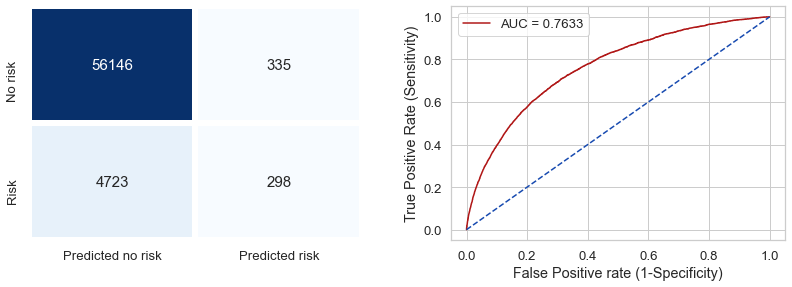

<IPython.core.display.Javascript object>

In [114]:
plot_algo_results(xboost_pipe, X_train, y_train, X_test, y_test)

We got results from the XGBoost model with default parameters. Looking at the results, we could say some things: our data is very imbalanced, secondly from the AUC graph we could say that data fitting good. Our model is performing very bad then we looked at confusion matrix, because model do not know how to learn minor class. In later steps we will try to apply variuos method which will help us to improve our model.

The first step - Hyperparameter tuning method with Optuna. Hyperparameter tuning works by running multiple trials in a single training job. Each trial is a complete execution of our training application with values for our chosen hyperparameters, set within limits we specify. The Optuna is an open-source automatic hyperparameter optimization framework, automates the trial-and-error process of optimizing the hyperparameters. It automatically finds optimal hyperparameter values based on an optimization target.

In [115]:
xboost_pipe_HT = ImPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("balancer", SMOTE(random_state=2)),
        (
            "classifier",
            XGBClassifier(
                eval_metric="auc", objective="binary:logistic", random_state=0
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

In [116]:
xboost_pipe_HT.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('balancer', SMOTE(random_state=2)),
                ('classifier',
                 XGBClassifier(base_score=0.5, booster='gbtree',
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, eval_metric='auc', gamma=0,
                               gpu_id=-1, importance_type='gain',
                               interaction_constraints='',
                               learning_rate=0.300000012, max_delta_step=0,
                               max_depth=6, min_child_weight=1, missing=nan,
                               monotone_constraints='()', n_estimators=100,
                               n_jobs=8, num_parallel_tree=1, random_state=0,
                               reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                               subsample=1, tree_method='exact',
                               validate_parameter

<IPython.core.display.Javascript object>

In [117]:
def objective(trial):
    colsample_bytree = int(trial.suggest_loguniform("colsample_bytree", 0.5, 1.0))
    min_child_weight = trial.suggest_int("min_child_weight", 5, 80)
    subsample = int(trial.suggest_loguniform("subsample", 0.5, 1.0))
    max_depth = int(trial.suggest_loguniform("max_depth", 1, 4))
    learning_rate = int(trial.suggest_loguniform("learning_rate", 0.001, 0.3))
    scale_pos_weight = trial.suggest_int("scale_pos_weight", 1, 5)
    reg_lambda = int(trial.suggest_loguniform("reg_lambda", 0.001, 1))
    reg_alpha = int(trial.suggest_loguniform("reg_alpha", 0.001, 1))
    n_estimators = trial.suggest_int("n_estimators", 50, 2000)

    pred_prob = xboost_pipe_HT.predict_proba(X_test)[:, 1]
    auc_score = metrics.roc_auc_score(y_test, pred_prob)
    return auc_score

<IPython.core.display.Javascript object>

In [118]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100)

[I 2022-01-21 20:26:56,317] A new study created in memory with name: no-name-1fe19fe4-f568-4e80-9c28-966fd06136ae
[I 2022-01-21 20:26:56,992] Trial 0 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.8933950652934026, 'min_child_weight': 56, 'subsample': 0.8178066736425433, 'max_depth': 2.5827363573354356, 'learning_rate': 0.21151181003042993, 'scale_pos_weight': 1, 'reg_lambda': 0.10018605129732883, 'reg_alpha': 0.009748357967237204, 'n_estimators': 681}. Best is trial 0 with value: 0.7633204752782423.
[I 2022-01-21 20:26:57,687] Trial 1 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.8148179876692292, 'min_child_weight': 76, 'subsample': 0.7565990164739799, 'max_depth': 1.6837977065870646, 'learning_rate': 0.050595215279247784, 'scale_pos_weight': 2, 'reg_lambda': 0.03591929287289237, 'reg_alpha': 0.0020204734493437107, 'n_estimators': 1309}. Best is trial 0 with value: 0.7633204752782423.
[I 2022-01-21 20:26:58,470] Trial 2

[I 2022-01-21 20:27:10,299] Trial 19 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.6598726963273887, 'min_child_weight': 28, 'subsample': 0.8619897645335631, 'max_depth': 3.140316617632928, 'learning_rate': 0.2306031707768361, 'scale_pos_weight': 1, 'reg_lambda': 0.09394233892646722, 'reg_alpha': 0.019382374560529343, 'n_estimators': 1087}. Best is trial 0 with value: 0.7633204752782423.
[I 2022-01-21 20:27:11,004] Trial 20 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.9852495966758633, 'min_child_weight': 52, 'subsample': 0.9471183710406482, 'max_depth': 2.763190866164367, 'learning_rate': 0.006793452462651366, 'scale_pos_weight': 4, 'reg_lambda': 0.8595872421381506, 'reg_alpha': 0.004628223147037451, 'n_estimators': 353}. Best is trial 0 with value: 0.7633204752782423.
[I 2022-01-21 20:27:11,801] Trial 21 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.8882328647656257, 'min_child_weight'

[I 2022-01-21 20:27:23,808] Trial 38 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.6337013051698746, 'min_child_weight': 27, 'subsample': 0.6934331139066672, 'max_depth': 3.5467056159335937, 'learning_rate': 0.006978618384335785, 'scale_pos_weight': 1, 'reg_lambda': 0.1483476586551002, 'reg_alpha': 0.018290622504261656, 'n_estimators': 1714}. Best is trial 0 with value: 0.7633204752782423.
[I 2022-01-21 20:27:24,508] Trial 39 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.7747101536717761, 'min_child_weight': 30, 'subsample': 0.568249386114229, 'max_depth': 2.9416806311678174, 'learning_rate': 0.12674801653387047, 'scale_pos_weight': 3, 'reg_lambda': 0.1917645431051083, 'reg_alpha': 0.007693263740024123, 'n_estimators': 1433}. Best is trial 0 with value: 0.7633204752782423.
[I 2022-01-21 20:27:25,193] Trial 40 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.6732347047631488, 'min_child_weigh

[I 2022-01-21 20:27:37,358] Trial 57 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.5873700012428505, 'min_child_weight': 5, 'subsample': 0.8077196891442359, 'max_depth': 1.4339501947475823, 'learning_rate': 0.0012312693757388924, 'scale_pos_weight': 5, 'reg_lambda': 0.028060049763672545, 'reg_alpha': 0.22437760831136444, 'n_estimators': 685}. Best is trial 0 with value: 0.7633204752782423.
[I 2022-01-21 20:27:38,073] Trial 58 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.5130284896429856, 'min_child_weight': 50, 'subsample': 0.706510568030862, 'max_depth': 1.4728408422276822, 'learning_rate': 0.193790188685477, 'scale_pos_weight': 5, 'reg_lambda': 0.015272423660649528, 'reg_alpha': 0.10436598287411487, 'n_estimators': 577}. Best is trial 0 with value: 0.7633204752782423.
[I 2022-01-21 20:27:38,773] Trial 59 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.5126531256614008, 'min_child_weight'

[I 2022-01-21 20:27:50,994] Trial 76 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.526402899987213, 'min_child_weight': 69, 'subsample': 0.7314970118606469, 'max_depth': 1.654844727547694, 'learning_rate': 0.002595848951553487, 'scale_pos_weight': 5, 'reg_lambda': 0.04180818794550221, 'reg_alpha': 0.43523466704060787, 'n_estimators': 615}. Best is trial 0 with value: 0.7633204752782423.
[I 2022-01-21 20:27:51,797] Trial 77 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.523421428106978, 'min_child_weight': 74, 'subsample': 0.7504506227686308, 'max_depth': 1.6353137063015952, 'learning_rate': 0.0031935086819048224, 'scale_pos_weight': 3, 'reg_lambda': 0.03165159380156032, 'reg_alpha': 0.021789461562607696, 'n_estimators': 925}. Best is trial 0 with value: 0.7633204752782423.
[I 2022-01-21 20:27:52,505] Trial 78 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.5591634464015078, 'min_child_weight

[I 2022-01-21 20:28:04,573] Trial 95 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.6878147733443476, 'min_child_weight': 31, 'subsample': 0.5965855039462535, 'max_depth': 3.079285776796692, 'learning_rate': 0.08019016110308004, 'scale_pos_weight': 2, 'reg_lambda': 0.5625966632175889, 'reg_alpha': 0.0010829475804346785, 'n_estimators': 1510}. Best is trial 0 with value: 0.7633204752782423.
[I 2022-01-21 20:28:05,263] Trial 96 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.7118597832584673, 'min_child_weight': 31, 'subsample': 0.5407012069406565, 'max_depth': 3.0493302491435115, 'learning_rate': 0.26319758847156893, 'scale_pos_weight': 2, 'reg_lambda': 0.188978551366634, 'reg_alpha': 0.002957794121384134, 'n_estimators': 1577}. Best is trial 0 with value: 0.7633204752782423.
[I 2022-01-21 20:28:05,984] Trial 97 finished with value: 0.7633204752782423 and parameters: {'colsample_bytree': 0.6439820926976156, 'min_child_weight

<IPython.core.display.Javascript object>

In [119]:
# print("Best hyperparameters: {}".format(study.best_params))

<IPython.core.display.Javascript object>

With help of OPTUNA we got results about parameters and will apply in our model.

In [120]:
xboost_pipe_HT = ImPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("balancer", SMOTE(random_state=2)),
        (
            "classifier",
            XGBClassifier(
                random_state=0,
                eval_metric="auc",
                objective="binary:logistic",
                colsample_bytree=0.9,
                min_child_weight=38,
                subsample=0.53,
                max_depth=3,
                learning_rate=0.05,
                scale_pos_weight=3,
                reg_lambda=0.05,
                reg_alpha=0.007,
                n_estimators=1626,
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.94      0.96      0.95     56481
           1       0.36      0.27      0.31      5021

    accuracy                           0.90     61502
   macro avg       0.65      0.61      0.63     61502
weighted avg       0.89      0.90      0.89     61502

AUC score: 0.7768474036144033
Accuracy Score:  0.9007186758154206


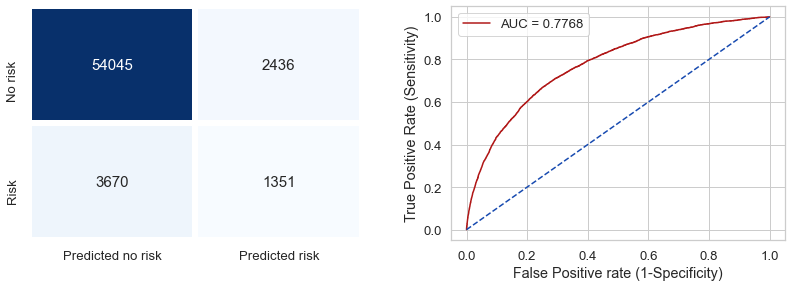

<IPython.core.display.Javascript object>

In [121]:
plot_algo_results(xboost_pipe_HT, X_train, y_train, X_test, y_test)

As we can see after hyperparameter tuning method we got better AUC score. But still looking deeper into our models performaces results, they are not so well. Especiallyy if we look at confusion matrix we can see that our model is hard to learn the minor class. So let'splay something with class weigths or sampling methods, maybe for our solution SMOTE is not the best solution.

**Adding class weights**

In [122]:
classes_weights = class_weight.compute_sample_weight(class_weight="balanced", y=y_train)

<IPython.core.display.Javascript object>

In [125]:
xboost_pipe_CWB = ImPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("balancer", SMOTE(random_state=2)),
        (
            "classifier",
            XGBClassifier(
                random_state=0,
                eval_metric="auc",
                objective="binary:logistic",
                colsample_bytree=0.9,
                min_child_weight=38,
                subsample=0.53,
                max_depth=3,
                learning_rate=0.05,
                scale_pos_weight=3,
                reg_lambda=0.05,
                reg_alpha=0.007,
                n_estimators=1626,
                sample_weight=classes_weights,
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

[21:11:56] WARNING: ..\src\learner.cc:541: 
Parameters: { sample_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           0       0.94      0.96      0.95     56481
           1       0.36      0.27      0.31      5021

    accuracy                           0.90     61502
   macro avg       0.65      0.61      0.63     61502
weighted avg       0.89      0.90      0.89     61502

AUC score: 0.7768474036144033
Accuracy Score:  0.9007186758154206


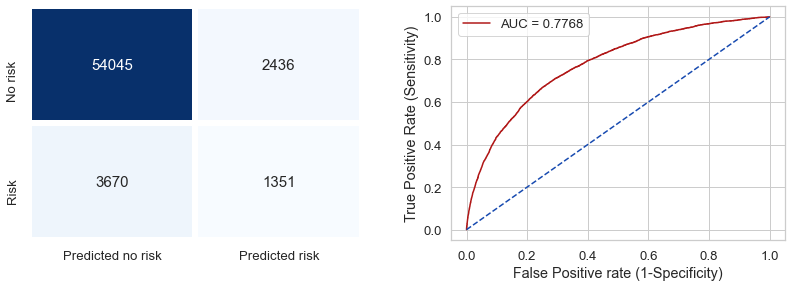

<IPython.core.display.Javascript object>

In [126]:
plot_algo_results(xboost_pipe_CWB, X_train, y_train, X_test, y_test)

When we added class weights to our model, we could notice that model AUC score is the same then before. Class weights not improve our model performance.

**Changing balancer to RandomOverSampler**

In [127]:
xboost_pipe_OS = ImPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("over", RandomOverSampler()),
        (
            "classifier",
            XGBClassifier(
                random_state=0,
                eval_metric="auc",
                objective="binary:logistic",
                colsample_bytree=0.9,
                min_child_weight=38,
                subsample=0.53,
                max_depth=3,
                learning_rate=0.05,
                scale_pos_weight=3,
                reg_lambda=0.05,
                reg_alpha=0.007,
                n_estimators=1626,
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.98      0.41      0.58     56481
           1       0.12      0.90      0.21      5021

    accuracy                           0.45     61502
   macro avg       0.55      0.66      0.40     61502
weighted avg       0.91      0.45      0.55     61502

AUC score: 0.7814734496905107
Accuracy Score:  0.45406653442164485


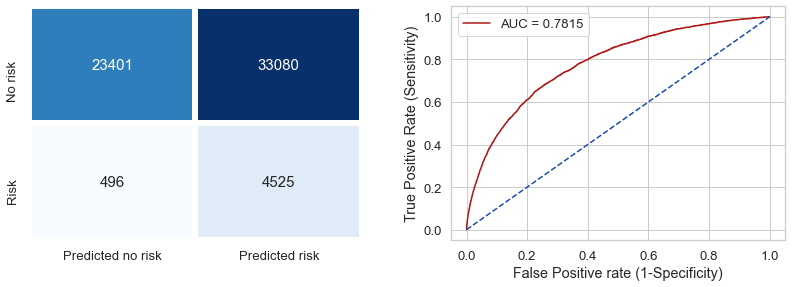

<IPython.core.display.Javascript object>

In [128]:
plot_algo_results(xboost_pipe_OS, X_train, y_train, X_test, y_test)

Here we got also high AUC score, but modle performing also changed. As we can see that know our model know how it could predict minor class but in the same time it making errors to predict majority classs. So here is the quesion what we want to get for our model: does not do any error or only predict defaulter.

**Changing balancer to RandomUnderSampler**

In [129]:
xboost_pipe_US = ImPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("under", RandomUnderSampler()),
        (
            "classifier",
            XGBClassifier(
                random_state=0,
                eval_metric="auc",
                objective="binary:logistic",
                colsample_bytree=0.9,
                min_child_weight=38,
                subsample=0.53,
                max_depth=3,
                learning_rate=0.05,
                scale_pos_weight=3,
                reg_lambda=0.05,
                reg_alpha=0.007,
                n_estimators=1626,
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

              precision    recall  f1-score   support

           0       0.98      0.38      0.55     56481
           1       0.12      0.91      0.21      5021

    accuracy                           0.43     61502
   macro avg       0.55      0.65      0.38     61502
weighted avg       0.91      0.43      0.52     61502

AUC score: 0.7777111190100425
Accuracy Score:  0.425530877044649


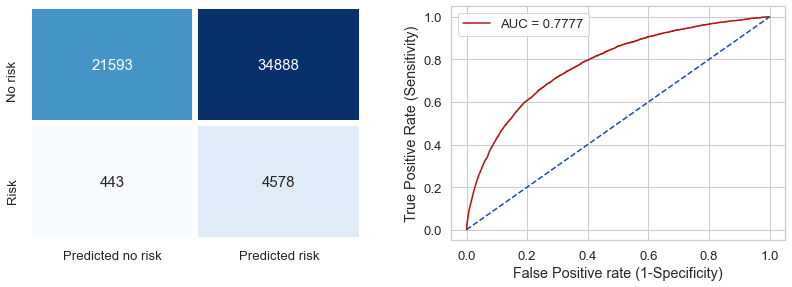

<IPython.core.display.Javascript object>

In [130]:
plot_algo_results(xboost_pipe_US, X_train, y_train, X_test, y_test)

This method seems to be worse then other methods, because we got lower AUC score and model is onlny concetrated to predict minor class - defaulters.

**Summary**

We applied some sampling methonds and the best was over sampler. This improve AUC score.

But also we have the problem - for model is hard to predict majority class. If we got better result of metric, but looking into detail report of confusion metric, we could say that now model coul not recognize if applicator do not have risk. So it is very important to get the clarified goal of bussness, because rigth now we could say where is the defaulter or not, but on the other hand we are not sure about who is really non defaulter.

Another method we will apply RandomOverSampler and adding class weights, maybe these two teqniques combination would be better for our model.

In [131]:
xboost_pipe_RO_C = ImPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("under", RandomOverSampler()),
        (
            "classifier",
            XGBClassifier(
                random_state=0,
                eval_metric="auc",
                objective="binary:logistic",
                colsample_bytree=0.9,
                min_child_weight=38,
                subsample=0.53,
                max_depth=3,
                learning_rate=0.05,
                scale_pos_weight=3,
                reg_lambda=0.05,
                reg_alpha=0.007,
                n_estimators=1626,
                sample_weight=classes_weights,
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

[21:58:39] WARNING: ..\src\learner.cc:541: 
Parameters: { sample_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           0       0.98      0.41      0.58     56481
           1       0.12      0.90      0.21      5021

    accuracy                           0.45     61502
   macro avg       0.55      0.66      0.40     61502
weighted avg       0.91      0.45      0.55     61502

AUC score: 0.7814544099534351
Accuracy Score:  0.45418035185847616


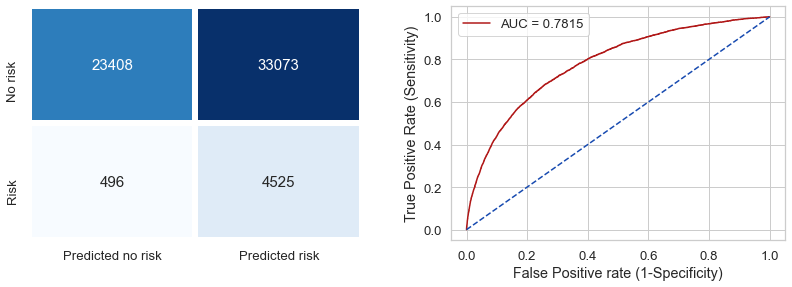

<IPython.core.display.Javascript object>

In [132]:
plot_algo_results(xboost_pipe_RO_C, X_train, y_train, X_test, y_test)

We got the same results then run model only with RandomOverSampler. In the next step we will calculate Threshold.

**Calculating threshold for model**

We can calculate and defien threshold for our model, it will make easier for model to decide which class is.

In [133]:
y_pred = xboost_pipe_RO_C.predict(X_test)
y_prob = xboost_pipe_RO_C.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_prob)
# calculate the g-mean for each threshold
gmeans = sqrt(tpr * (1 - fpr))
# locate the index of the largest g-mean
ix = argmax(gmeans)
print("Best Threshold=%f, G-Mean=%.3f" % (thresholds[ix], gmeans[ix]))

Best Threshold=0.733437, G-Mean=0.711


<IPython.core.display.Javascript object>

In [137]:
xboost_pipe_TH = ImPipeline(
    [
        ("imputer", SimpleImputer()),
        ("scaler", StandardScaler()),
        ("under", RandomOverSampler()),
        (
            "classifier",
            XGBClassifier(
                random_state=0,
                base_rate=0.73,
                eval_metric="auc",
                objective="binary:logistic",
                colsample_bytree=0.9,
                min_child_weight=38,
                subsample=0.53,
                max_depth=3,
                learning_rate=0.05,
                scale_pos_weight=3,
                reg_lambda=0.05,
                reg_alpha=0.007,
                n_estimators=1626,
                sample_weight=classes_weights,
            ),
        ),
    ]
)

<IPython.core.display.Javascript object>

[22:37:16] WARNING: ..\src\learner.cc:541: 
Parameters: { base_rate, sample_weight } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


              precision    recall  f1-score   support

           0       0.98      0.41      0.58     56481
           1       0.12      0.90      0.21      5021

    accuracy                           0.45     61502
   macro avg       0.55      0.66      0.40     61502
weighted avg       0.91      0.45      0.55     61502

AUC score: 0.781945465559584
Accuracy Score:  0.45322103346232645


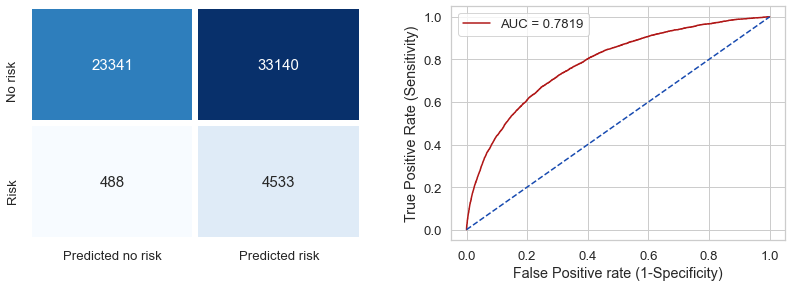

<IPython.core.display.Javascript object>

In [138]:
plot_algo_results(xboost_pipe_TH, X_train, y_train, X_test, y_test)

The AUC score is the better then before model. But as we can see our model could recognize defaulters and this is our problem which we try to solve. On the other hand we are meeting errors to decide who have not a risk.

Model selection conclusions:
- firstly we selected model
- applied hyperparameter tuning
- applied variuos methods to fix imbalanced dataset
- combine better teqniques
- finding best tresholding

**We can conclude the above model results:**

1. Firstly, we selecte the best model by AUC score - XGBoost model
2. Applied following steps: baseline, PCA method, Hyperparameter tuning method, added classs weights for imbalanced data, tried another sampling method, add threshold.
3. After many improvements steps we could recognize that the best fit was after hyperparameters tunning method.

In [136]:
# for app exporting model
import pickle

pickle.dump(xboost_pipe_TH, open("model.pkl", "wb"))

<IPython.core.display.Javascript object>

# 8. Conclusion

**Summary**
1. Explored datasets.
2. Visulaization of few features who had strongest relationships between them and target.
3. Applied statistics inferences.
4. Applied features enegeenering part.
5. Used model to select features.
6. Trained few baselina models.
7. For the best model were applied improvements steps.

**About Defaulters prediction**
- The XGBoost Classifier was choose, because got higher AUC score.
- Applied various methods to improve the AUC result and model performing.


For improvements:
1. Get more data, in which would be more about defaulters.
2. Try more methods to reduce dimensionalities.
3. Try different approch to find out more parameters for models.